In [119]:
import sklearn
from sklearn import datasets

import matplotlib.pyplot as plt
import numpy as np

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

USE_GPU = False


torch_device = torch.device('cpu')
if USE_GPU:
    torch_device = torch.device('cuda')
    
torch_dtype = torch.float

# MNIST DATASET

In [3]:
mnist_dataset = datasets.fetch_openml('mnist_784', version=1)

In [123]:
X = mnist_dataset['data'].reshape((-1, 1, 28, 28))/255.
Y = np.array(list(map(int, mnist_dataset['target'])))

X = torch.from_numpy(X).type(torch_dtype).to(torch_device)
Y = torch.from_numpy(Y).type(torch.long).to(torch_device)

print(X.shape)
print(Y.shape)

X_train = X[:60000]
Y_train = Y[:60000]

X_test = X[60000:]
Y_test = Y[60000:]

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

torch.Size([70000, 1, 28, 28])
torch.Size([70000])
torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


### MNIST Images

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


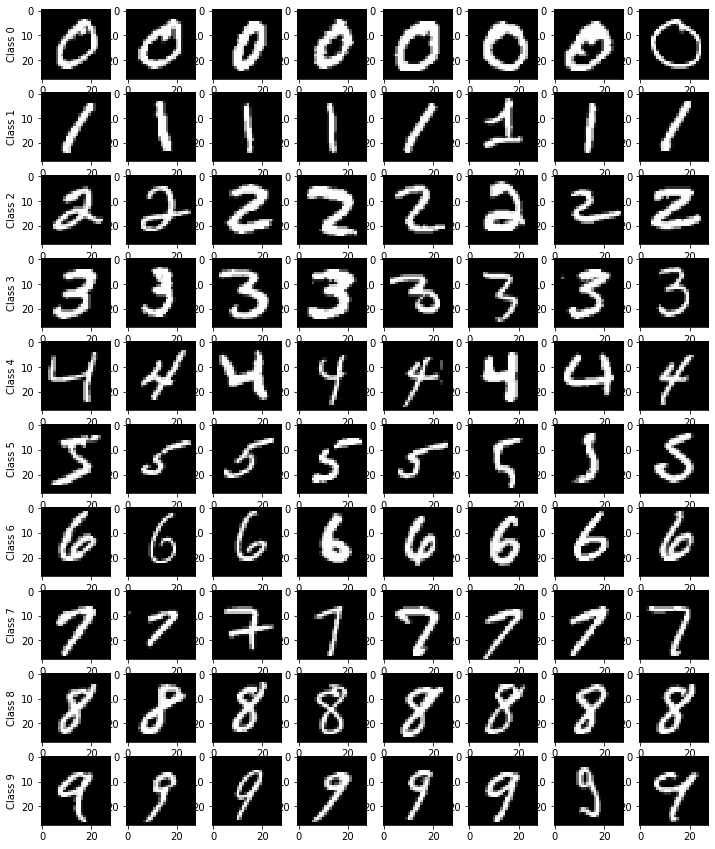

In [124]:
%matplotlib inline

rows = 10
cols = 8

fig, axs = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
for y in range(rows):
    imgs = X[Y==y]
    for x in range(cols):
        img = imgs[x].cpu().numpy()
        axs[y, x].imshow(img[0], cmap='gray')
    axs[y, 0].set_ylabel(f'Class {y}')
fig.show()

In [126]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

    def forward(self, x):
        # b, 1, 28, 28
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # b, 6, 14, 14
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # b, 16, 7, 7
        x = x.view(-1, 16 * 7 * 7)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
    
    
    def fit(self, X, Y, epochs=1, batch_size=32):
        for epoch in range(epochs):
            print(f'Epoch {epoch}\n--------------------------------')
            running_loss = 0.0
            batch_pbar = tqdm(range(int(math.ceil(X_train.shape[0]/batch_size))))
            for batch_i in batch_pbar:
                X_batch = X[batch_i*batch_size: (batch_i+1)*batch_size]
                Y_batch = Y[batch_i*batch_size: (batch_i+1)*batch_size]

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                Y_batch_pred = self(X_batch)
                loss = self.criterion(Y_batch_pred, Y_batch)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if batch_i % 100 == 0 and batch_i != 0:    # print every 100 mini-batches
#                     batch_pbar.set_description(f'100 Batch Loss: {running_loss}')
                    print(f'100 Batch Loss: {running_loss}')
                    running_loss = 0.0


mnist_net = MnistNet().type(torch_dtype).to(torch_device)

In [165]:
def show_performance(Y_train, Y_train_pred, Y_test, Y_test_pred):
    acc_train = (Y_train==Y_train_pred).sum().item() / Y_train.size()[0]
    acc_test = (Y_test==Y_test_pred).sum().item() / Y_test.size()[0]

    print('Training accuracy: ', acc_train)
    print('Testing accuracy: ', acc_test)

    %matplotlib inline
    plt.subplot(2, 2, 1)
    plt.hist(Y_train_pred, color='b', bins=10)
    plt.title('Training set predictions')
    plt.xlabel('none')

    plt.subplot(2, 2, 2)
    plt.hist(Y_train, color='r', bins=10)
    plt.title('Training set actual')

    plt.subplot(2, 2, 3)
    plt.hist(Y_test_pred, color='b', bins=10)
    plt.title('Testing set predictions')

    plt.subplot(2, 2, 4)
    plt.hist(Y_test, color='r', bins=10)
    plt.title('Testing set actual')

    plt.show()

Training accuracy:  0.10218333333333333
Testing accuracy:  0.101


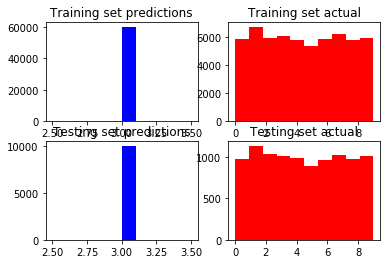

In [166]:
Y_train_pred = mnist_net.forward(X_train).detach().cpu().argmax(axis=1)
Y_test_pred = mnist_net.forward(X_test).detach().cpu().argmax(axis=1)
show_performance(Y_train, Y_train_pred, Y_test, Y_test_pred)

In [168]:
mnist_net.fit(X_train, Y_train, epochs=1)









  0%|          | 0/1875 [00:00<?, ?it/s]







  0%|          | 2/1875 [00:00<01:43, 18.12it/s]

Epoch 0
--------------------------------










  0%|          | 8/1875 [00:00<01:22, 22.70it/s]







  1%|          | 14/1875 [00:00<01:07, 27.69it/s]







  1%|          | 22/1875 [00:00<00:54, 33.81it/s]







  2%|▏         | 29/1875 [00:00<00:46, 39.46it/s]







  2%|▏         | 36/1875 [00:00<00:41, 44.51it/s]







  2%|▏         | 43/1875 [00:00<00:37, 49.33it/s]







  3%|▎         | 50/1875 [00:00<00:34, 53.39it/s]







  3%|▎         | 57/1875 [00:00<00:31, 57.38it/s]







  3%|▎         | 64/1875 [00:01<00:32, 56.30it/s]







  4%|▍         | 71/1875 [00:01<00:30, 58.32it/s]







  4%|▍         | 78/1875 [00:01<00:32, 55.36it/s]







  5%|▍         | 85/1875 [00:01<00:30, 58.20it/s]







  5%|▍         | 93/1875 [00:01<00:28, 62.40it/s]







  5%|▌         | 100/1875 [00:01<00:27, 63.85it/s]







  6%|▌         | 107/1875 [00:01<00:33, 52.10it/s]

100 Batch Loss: 232.55724549293518










  6%|▌         | 113/1875 [00:01<00:35, 50.27it/s]







  6%|▋         | 121/1875 [00:02<00:31, 55.91it/s]







  7%|▋         | 129/1875 [00:02<00:29, 60.13it/s]







  7%|▋         | 136/1875 [00:02<00:28, 62.04it/s]







  8%|▊         | 144/1875 [00:02<00:26, 64.52it/s]







  8%|▊         | 151/1875 [00:02<00:26, 63.97it/s]







  8%|▊         | 158/1875 [00:02<00:29, 58.21it/s]







  9%|▉         | 165/1875 [00:02<00:31, 54.12it/s]







  9%|▉         | 171/1875 [00:02<00:32, 52.39it/s]







 10%|▉         | 179/1875 [00:03<00:29, 57.42it/s]







 10%|▉         | 187/1875 [00:03<00:27, 61.64it/s]







 10%|█         | 195/1875 [00:03<00:25, 64.74it/s]







 11%|█         | 202/1875 [00:03<00:25, 65.80it/s]







 11%|█         | 209/1875 [00:03<00:26, 63.27it/s]

100 Batch Loss: 230.22958183288574










 12%|█▏        | 216/1875 [00:03<00:25, 64.50it/s]







 12%|█▏        | 223/1875 [00:03<00:25, 65.68it/s]







 12%|█▏        | 230/1875 [00:03<00:27, 60.92it/s]







 13%|█▎        | 237/1875 [00:03<00:28, 57.74it/s]







 13%|█▎        | 243/1875 [00:04<00:29, 56.03it/s]







 13%|█▎        | 249/1875 [00:04<00:29, 55.60it/s]







 14%|█▎        | 255/1875 [00:04<00:29, 55.53it/s]







 14%|█▍        | 261/1875 [00:04<00:28, 56.61it/s]







 14%|█▍        | 267/1875 [00:04<00:28, 56.12it/s]







 15%|█▍        | 273/1875 [00:04<00:28, 57.11it/s]







 15%|█▍        | 281/1875 [00:04<00:27, 58.61it/s]







 15%|█▌        | 287/1875 [00:04<00:28, 56.65it/s]







 16%|█▌        | 293/1875 [00:04<00:28, 56.40it/s]







 16%|█▌        | 299/1875 [00:05<00:29, 54.06it/s]







 16%|█▋        | 305/1875 [00:05<00:29, 53.96it/s]







 17%|█▋        | 311/1875 [00:05<00:28, 54.90it/s]

100 Batch Loss: 230.2145402431488










 17%|█▋        | 317/1875 [00:05<00:29, 52.81it/s]







 17%|█▋        | 323/1875 [00:05<00:30, 51.72it/s]







 18%|█▊        | 329/1875 [00:05<00:29, 52.56it/s]







 18%|█▊        | 335/1875 [00:05<00:28, 54.08it/s]







 18%|█▊        | 341/1875 [00:05<00:27, 54.84it/s]







 19%|█▊        | 347/1875 [00:06<00:30, 50.16it/s]







 19%|█▉        | 354/1875 [00:06<00:27, 54.44it/s]







 19%|█▉        | 360/1875 [00:06<00:29, 51.64it/s]







 20%|█▉        | 366/1875 [00:06<00:29, 52.01it/s]







 20%|█▉        | 372/1875 [00:06<00:28, 53.65it/s]







 20%|██        | 379/1875 [00:06<00:26, 55.63it/s]







 21%|██        | 385/1875 [00:06<00:26, 55.83it/s]







 21%|██        | 391/1875 [00:06<00:26, 55.00it/s]







 21%|██        | 397/1875 [00:06<00:27, 54.23it/s]







 22%|██▏       | 404/1875 [00:07<00:26, 55.89it/s]







 22%|██▏       | 411/1875 [00:07<00:25, 57.42it/s]

100 Batch Loss: 230.19075560569763










 22%|██▏       | 417/1875 [00:07<00:25, 57.83it/s]







 23%|██▎       | 423/1875 [00:07<00:26, 55.20it/s]







 23%|██▎       | 429/1875 [00:07<00:27, 51.87it/s]







 23%|██▎       | 435/1875 [00:07<00:28, 50.99it/s]







 24%|██▎       | 441/1875 [00:07<00:26, 53.16it/s]







 24%|██▍       | 447/1875 [00:07<00:26, 54.61it/s]







 24%|██▍       | 453/1875 [00:07<00:25, 56.07it/s]







 25%|██▍       | 460/1875 [00:08<00:26, 54.27it/s]







 25%|██▍       | 466/1875 [00:08<00:25, 55.71it/s]







 25%|██▌       | 473/1875 [00:08<00:23, 58.88it/s]







 26%|██▌       | 480/1875 [00:08<00:23, 59.65it/s]







 26%|██▌       | 488/1875 [00:08<00:22, 62.70it/s]







 26%|██▋       | 495/1875 [00:08<00:21, 64.18it/s]







 27%|██▋       | 502/1875 [00:08<00:21, 63.81it/s]







 27%|██▋       | 509/1875 [00:08<00:21, 64.46it/s]

100 Batch Loss: 230.1668906211853










 28%|██▊       | 517/1875 [00:08<00:21, 64.08it/s]







 28%|██▊       | 525/1875 [00:09<00:20, 67.36it/s]







 28%|██▊       | 533/1875 [00:09<00:19, 68.38it/s]







 29%|██▉       | 541/1875 [00:09<00:19, 69.26it/s]







 29%|██▉       | 549/1875 [00:09<00:18, 70.54it/s]







 30%|██▉       | 557/1875 [00:09<00:18, 70.63it/s]







 30%|███       | 565/1875 [00:09<00:18, 71.92it/s]







 31%|███       | 573/1875 [00:09<00:19, 65.63it/s]







 31%|███       | 580/1875 [00:09<00:21, 60.15it/s]







 31%|███▏      | 587/1875 [00:10<00:21, 59.89it/s]







 32%|███▏      | 594/1875 [00:10<00:22, 57.84it/s]







 32%|███▏      | 600/1875 [00:10<00:22, 55.70it/s]







 32%|███▏      | 606/1875 [00:10<00:22, 55.98it/s]







 33%|███▎      | 612/1875 [00:10<00:22, 55.41it/s]

100 Batch Loss: 230.1180067062378










 33%|███▎      | 618/1875 [00:10<00:22, 55.31it/s]







 33%|███▎      | 624/1875 [00:10<00:22, 54.91it/s]







 34%|███▎      | 630/1875 [00:10<00:22, 54.32it/s]







 34%|███▍      | 637/1875 [00:10<00:21, 56.50it/s]







 34%|███▍      | 644/1875 [00:11<00:21, 58.22it/s]







 35%|███▍      | 650/1875 [00:11<00:21, 56.18it/s]







 35%|███▍      | 656/1875 [00:11<00:21, 55.57it/s]







 35%|███▌      | 662/1875 [00:11<00:21, 56.53it/s]







 36%|███▌      | 669/1875 [00:11<00:20, 58.12it/s]







 36%|███▌      | 676/1875 [00:11<00:20, 59.40it/s]







 36%|███▋      | 683/1875 [00:11<00:19, 59.97it/s]







 37%|███▋      | 690/1875 [00:11<00:19, 59.55it/s]







 37%|███▋      | 696/1875 [00:11<00:20, 57.49it/s]







 37%|███▋      | 702/1875 [00:12<00:21, 55.15it/s]







 38%|███▊      | 709/1875 [00:12<00:20, 57.06it/s]

100 Batch Loss: 230.05933380126953










 38%|███▊      | 717/1875 [00:12<00:18, 61.45it/s]







 39%|███▊      | 725/1875 [00:12<00:18, 63.66it/s]







 39%|███▉      | 733/1875 [00:12<00:17, 66.35it/s]







 40%|███▉      | 741/1875 [00:12<00:16, 68.66it/s]







 40%|███▉      | 749/1875 [00:12<00:16, 70.22it/s]







 40%|████      | 757/1875 [00:12<00:15, 71.25it/s]







 41%|████      | 765/1875 [00:12<00:15, 72.27it/s]







 41%|████      | 773/1875 [00:13<00:15, 72.24it/s]







 42%|████▏     | 781/1875 [00:13<00:15, 72.44it/s]







 42%|████▏     | 789/1875 [00:13<00:14, 72.78it/s]







 43%|████▎     | 797/1875 [00:13<00:14, 74.69it/s]







 43%|████▎     | 805/1875 [00:13<00:14, 74.01it/s]







 43%|████▎     | 813/1875 [00:13<00:14, 73.88it/s]

100 Batch Loss: 229.97623896598816










 44%|████▍     | 821/1875 [00:13<00:14, 73.52it/s]







 44%|████▍     | 829/1875 [00:13<00:14, 73.53it/s]







 45%|████▍     | 837/1875 [00:13<00:13, 74.39it/s]







 45%|████▌     | 845/1875 [00:14<00:14, 72.43it/s]







 45%|████▌     | 853/1875 [00:14<00:14, 68.45it/s]







 46%|████▌     | 860/1875 [00:14<00:15, 64.39it/s]







 46%|████▌     | 867/1875 [00:14<00:16, 60.76it/s]







 47%|████▋     | 874/1875 [00:14<00:16, 60.10it/s]







 47%|████▋     | 881/1875 [00:14<00:16, 59.93it/s]







 47%|████▋     | 888/1875 [00:14<00:17, 57.70it/s]







 48%|████▊     | 894/1875 [00:14<00:17, 56.50it/s]







 48%|████▊     | 901/1875 [00:14<00:16, 58.98it/s]







 48%|████▊     | 908/1875 [00:15<00:15, 60.94it/s]

100 Batch Loss: 229.75642919540405










 49%|████▉     | 915/1875 [00:15<00:15, 61.96it/s]







 49%|████▉     | 922/1875 [00:15<00:14, 64.07it/s]







 50%|████▉     | 930/1875 [00:15<00:14, 66.24it/s]







 50%|█████     | 938/1875 [00:15<00:13, 68.88it/s]







 50%|█████     | 946/1875 [00:15<00:13, 70.18it/s]







 51%|█████     | 954/1875 [00:15<00:13, 70.74it/s]







 51%|█████▏    | 962/1875 [00:15<00:12, 71.18it/s]







 52%|█████▏    | 970/1875 [00:15<00:12, 72.67it/s]







 52%|█████▏    | 978/1875 [00:16<00:12, 70.17it/s]







 53%|█████▎    | 986/1875 [00:16<00:14, 61.27it/s]







 53%|█████▎    | 993/1875 [00:16<00:15, 58.23it/s]







 53%|█████▎    | 1000/1875 [00:16<00:15, 56.28it/s]







 54%|█████▎    | 1006/1875 [00:16<00:15, 56.29it/s]







 54%|█████▍    | 1012/1875 [00:16<00:15, 55.64it/s]

100 Batch Loss: 229.16830253601074










 54%|█████▍    | 1018/1875 [00:16<00:15, 56.07it/s]







 55%|█████▍    | 1024/1875 [00:16<00:15, 55.80it/s]







 55%|█████▍    | 1030/1875 [00:17<00:15, 56.30it/s]







 55%|█████▌    | 1036/1875 [00:17<00:15, 55.22it/s]







 56%|█████▌    | 1043/1875 [00:17<00:14, 57.55it/s]







 56%|█████▌    | 1051/1875 [00:17<00:13, 62.66it/s]







 56%|█████▋    | 1059/1875 [00:17<00:12, 66.03it/s]







 57%|█████▋    | 1067/1875 [00:17<00:11, 67.84it/s]







 57%|█████▋    | 1075/1875 [00:17<00:11, 69.89it/s]







 58%|█████▊    | 1083/1875 [00:17<00:11, 71.37it/s]







 58%|█████▊    | 1091/1875 [00:17<00:11, 65.86it/s]







 59%|█████▊    | 1098/1875 [00:18<00:13, 57.43it/s]







 59%|█████▉    | 1105/1875 [00:18<00:14, 54.45it/s]







 59%|█████▉    | 1111/1875 [00:18<00:14, 53.78it/s]

100 Batch Loss: 222.28374671936035










 60%|█████▉    | 1117/1875 [00:18<00:13, 54.70it/s]







 60%|█████▉    | 1123/1875 [00:18<00:13, 54.20it/s]







 60%|██████    | 1130/1875 [00:18<00:13, 56.44it/s]







 61%|██████    | 1136/1875 [00:18<00:13, 54.02it/s]







 61%|██████    | 1142/1875 [00:18<00:14, 51.48it/s]







 61%|██████    | 1148/1875 [00:19<00:13, 51.95it/s]







 62%|██████▏   | 1154/1875 [00:19<00:14, 51.40it/s]







 62%|██████▏   | 1160/1875 [00:19<00:13, 51.56it/s]







 62%|██████▏   | 1166/1875 [00:19<00:13, 50.76it/s]







 63%|██████▎   | 1172/1875 [00:19<00:13, 52.76it/s]







 63%|██████▎   | 1178/1875 [00:19<00:12, 54.54it/s]







 63%|██████▎   | 1184/1875 [00:19<00:12, 53.82it/s]







 63%|██████▎   | 1190/1875 [00:19<00:12, 55.22it/s]







 64%|██████▍   | 1196/1875 [00:19<00:12, 55.29it/s]







 64%|██████▍   | 1203/1875 [00:20<00:11, 57.51it/s]







 65%|██████▍   | 1210/1875 [00:20<00:10, 60.54it/s]

100 Batch Loss: 191.19368493556976










 65%|██████▍   | 1217/1875 [00:20<00:11, 59.64it/s]







 65%|██████▌   | 1224/1875 [00:20<00:11, 59.00it/s]







 66%|██████▌   | 1230/1875 [00:20<00:11, 57.10it/s]







 66%|██████▌   | 1236/1875 [00:20<00:11, 57.27it/s]







 66%|██████▌   | 1242/1875 [00:20<00:11, 56.16it/s]







 67%|██████▋   | 1248/1875 [00:20<00:11, 55.04it/s]







 67%|██████▋   | 1255/1875 [00:20<00:10, 56.96it/s]







 67%|██████▋   | 1262/1875 [00:21<00:10, 58.89it/s]







 68%|██████▊   | 1268/1875 [00:21<00:10, 56.93it/s]







 68%|██████▊   | 1275/1875 [00:21<00:10, 58.59it/s]







 68%|██████▊   | 1281/1875 [00:21<00:10, 56.84it/s]







 69%|██████▊   | 1288/1875 [00:21<00:10, 58.28it/s]







 69%|██████▉   | 1294/1875 [00:21<00:10, 57.78it/s]







 69%|██████▉   | 1301/1875 [00:21<00:09, 59.29it/s]







 70%|██████▉   | 1308/1875 [00:21<00:09, 59.93it/s]

100 Batch Loss: 181.7356653213501










 70%|███████   | 1315/1875 [00:21<00:09, 61.55it/s]







 71%|███████   | 1322/1875 [00:22<00:08, 61.47it/s]







 71%|███████   | 1329/1875 [00:22<00:09, 59.82it/s]







 71%|███████▏  | 1336/1875 [00:22<00:09, 58.40it/s]







 72%|███████▏  | 1342/1875 [00:22<00:09, 58.14it/s]







 72%|███████▏  | 1349/1875 [00:22<00:08, 59.31it/s]







 72%|███████▏  | 1356/1875 [00:22<00:08, 60.98it/s]







 73%|███████▎  | 1363/1875 [00:22<00:08, 61.95it/s]







 73%|███████▎  | 1370/1875 [00:22<00:07, 63.99it/s]







 73%|███████▎  | 1378/1875 [00:22<00:07, 66.29it/s]







 74%|███████▍  | 1386/1875 [00:23<00:07, 68.00it/s]







 74%|███████▍  | 1394/1875 [00:23<00:06, 69.51it/s]







 75%|███████▍  | 1402/1875 [00:23<00:06, 70.03it/s]







 75%|███████▌  | 1410/1875 [00:23<00:07, 61.36it/s]

100 Batch Loss: 179.19801700115204










 76%|███████▌  | 1417/1875 [00:23<00:07, 59.58it/s]







 76%|███████▌  | 1424/1875 [00:23<00:07, 59.70it/s]







 76%|███████▋  | 1431/1875 [00:23<00:07, 57.87it/s]







 77%|███████▋  | 1438/1875 [00:23<00:07, 59.62it/s]







 77%|███████▋  | 1446/1875 [00:24<00:06, 62.97it/s]







 77%|███████▋  | 1453/1875 [00:24<00:06, 64.31it/s]







 78%|███████▊  | 1460/1875 [00:24<00:06, 62.02it/s]







 78%|███████▊  | 1467/1875 [00:24<00:06, 59.88it/s]







 79%|███████▊  | 1474/1875 [00:24<00:06, 61.16it/s]







 79%|███████▉  | 1481/1875 [00:24<00:06, 63.39it/s]







 79%|███████▉  | 1488/1875 [00:24<00:05, 64.75it/s]







 80%|███████▉  | 1495/1875 [00:24<00:05, 66.04it/s]







 80%|████████  | 1502/1875 [00:24<00:05, 66.91it/s]







 81%|████████  | 1510/1875 [00:25<00:05, 69.13it/s]

100 Batch Loss: 168.6639642715454










 81%|████████  | 1519/1875 [00:25<00:04, 71.85it/s]







 81%|████████▏ | 1527/1875 [00:25<00:04, 70.24it/s]







 82%|████████▏ | 1535/1875 [00:25<00:04, 69.17it/s]







 82%|████████▏ | 1543/1875 [00:25<00:04, 70.09it/s]







 83%|████████▎ | 1551/1875 [00:25<00:04, 69.33it/s]







 83%|████████▎ | 1558/1875 [00:25<00:05, 63.06it/s]







 83%|████████▎ | 1565/1875 [00:25<00:05, 59.90it/s]







 84%|████████▍ | 1572/1875 [00:25<00:05, 59.43it/s]







 84%|████████▍ | 1579/1875 [00:26<00:04, 59.72it/s]







 85%|████████▍ | 1586/1875 [00:26<00:04, 59.07it/s]







 85%|████████▍ | 1592/1875 [00:26<00:05, 55.35it/s]







 85%|████████▌ | 1598/1875 [00:26<00:05, 55.12it/s]







 86%|████████▌ | 1604/1875 [00:26<00:04, 55.09it/s]







 86%|████████▌ | 1610/1875 [00:26<00:05, 52.96it/s]

100 Batch Loss: 168.54094994068146










 86%|████████▌ | 1616/1875 [00:26<00:05, 50.62it/s]







 87%|████████▋ | 1622/1875 [00:26<00:04, 51.36it/s]







 87%|████████▋ | 1628/1875 [00:27<00:04, 52.34it/s]







 87%|████████▋ | 1634/1875 [00:27<00:04, 52.22it/s]







 87%|████████▋ | 1640/1875 [00:27<00:04, 51.46it/s]







 88%|████████▊ | 1646/1875 [00:27<00:04, 50.40it/s]







 88%|████████▊ | 1652/1875 [00:27<00:04, 51.39it/s]







 88%|████████▊ | 1658/1875 [00:27<00:04, 53.06it/s]







 89%|████████▊ | 1664/1875 [00:27<00:04, 52.35it/s]







 89%|████████▉ | 1670/1875 [00:27<00:03, 51.82it/s]







 89%|████████▉ | 1676/1875 [00:27<00:03, 50.59it/s]







 90%|████████▉ | 1682/1875 [00:28<00:03, 50.47it/s]







 90%|█████████ | 1688/1875 [00:28<00:03, 51.77it/s]







 90%|█████████ | 1694/1875 [00:28<00:03, 52.96it/s]







 91%|█████████ | 1700/1875 [00:28<00:03, 54.01it/s]







 91%|█████████ | 1706/1875 [00:28<00:03, 53.87it/s]







 91%|█████████▏| 1712/1875 [00:28<00:02, 54.98it

100 Batch Loss: 165.3188101053238










 92%|█████████▏| 1718/1875 [00:28<00:02, 56.08it/s]







 92%|█████████▏| 1724/1875 [00:28<00:02, 55.99it/s]







 92%|█████████▏| 1730/1875 [00:28<00:02, 56.58it/s]







 93%|█████████▎| 1737/1875 [00:29<00:02, 59.66it/s]







 93%|█████████▎| 1745/1875 [00:29<00:02, 62.48it/s]







 93%|█████████▎| 1752/1875 [00:29<00:01, 63.61it/s]







 94%|█████████▍| 1759/1875 [00:29<00:02, 57.04it/s]







 94%|█████████▍| 1766/1875 [00:29<00:01, 60.11it/s]







 95%|█████████▍| 1773/1875 [00:29<00:01, 59.65it/s]







 95%|█████████▍| 1780/1875 [00:29<00:01, 57.83it/s]







 95%|█████████▌| 1786/1875 [00:29<00:01, 56.07it/s]







 96%|█████████▌| 1792/1875 [00:30<00:01, 55.32it/s]







 96%|█████████▌| 1798/1875 [00:30<00:01, 55.41it/s]







 96%|█████████▌| 1804/1875 [00:30<00:01, 55.91it/s]







 97%|█████████▋| 1810/1875 [00:30<00:01, 56.80it/s]

100 Batch Loss: 162.44529688358307










 97%|█████████▋| 1816/1875 [00:30<00:01, 56.63it/s]







 97%|█████████▋| 1823/1875 [00:30<00:00, 57.11it/s]







 98%|█████████▊| 1829/1875 [00:30<00:00, 54.69it/s]







 98%|█████████▊| 1835/1875 [00:30<00:00, 53.61it/s]







 98%|█████████▊| 1841/1875 [00:30<00:00, 53.29it/s]







 99%|█████████▊| 1848/1875 [00:31<00:00, 57.28it/s]







 99%|█████████▉| 1854/1875 [00:31<00:00, 51.46it/s]







 99%|█████████▉| 1861/1875 [00:31<00:00, 54.14it/s]







100%|█████████▉| 1868/1875 [00:31<00:00, 56.55it/s]







100%|██████████| 1875/1875 [00:31<00:00, 59.55it/s]


Training accuracy:  0.8354
Testing accuracy:  0.8425


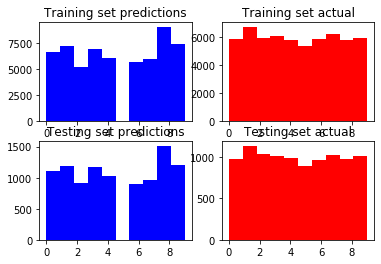

In [170]:
Y_train_pred = mnist_net.forward(X_train).detach().cpu().argmax(axis=1)
Y_test_pred = mnist_net.forward(X_test).detach().cpu().argmax(axis=1)
show_performance(Y_train, Y_train_pred, Y_test, Y_test_pred)

# CIFAR 10 DATASET

In [48]:
cifar10_dataset = datasets.fetch_openml('CIFAR_10')

In [182]:
X = cifar10_dataset['data'].reshape((-1, 3, 32, 32))/255.
Y = np.array(list(map(int, cifar10_dataset['target'])))

X = np.rot90(X, 1, axes=(2, 3))

X = torch.from_numpy(X.copy()).type(torch_dtype).to(torch_device)
Y = torch.from_numpy(Y).type(torch.long).to(torch_device)

print(X.shape)
print(Y.shape)

X_train = X[:50000]
Y_train = Y[:50000]

X_test = X[50000:]
Y_test = Y[50000:]

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

torch.Size([60000, 3, 32, 32])
torch.Size([60000])
torch.Size([50000, 3, 32, 32])
torch.Size([50000])
torch.Size([10000, 3, 32, 32])
torch.Size([10000])


## CIFAR-10 Images

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


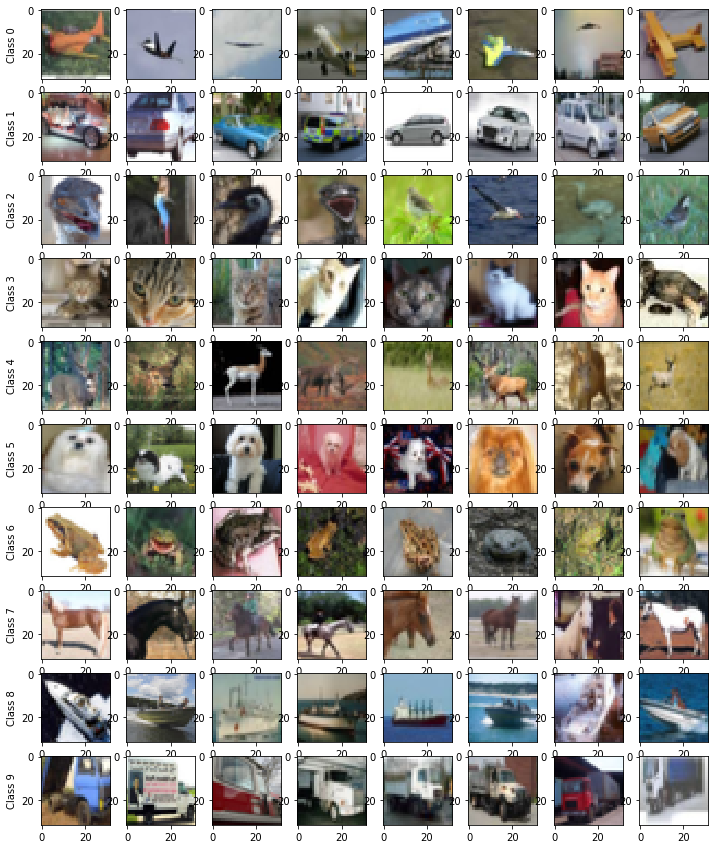

In [183]:
%matplotlib inline

rows = 10
cols = 8

fig, axs = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
for y in range(rows):
    imgs = X[Y==y]
    for x in range(cols):
        img = imgs[x].cpu().numpy()
        axs[y, x].imshow(img.swapaxes(0,-1))
    axs[y, 0].set_ylabel(f'Class {y}')
fig.show()

In [184]:
class Cifar10Net(nn.Module):
    def __init__(self):
        super(Cifar10Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

    def forward(self, x):
        # b, 3, 32, 32
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # b, 6, 16, 16
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # b, 16, 8, 8
        x = x.view(-1, 16 * 8 * 8)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
    
    
    def fit(self, X, Y, epochs=1, batch_size=32):
        for epoch in range(epochs):
            print(f'Epoch {epoch}\n--------------------------------')
            running_loss = 0.0
            batch_pbar = tqdm(range(int(math.ceil(X_train.shape[0]/batch_size))))
            for batch_i in batch_pbar:
                X_batch = X[batch_i*batch_size: (batch_i+1)*batch_size]
                Y_batch = Y[batch_i*batch_size: (batch_i+1)*batch_size]

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                Y_batch_pred = self(X_batch)
                loss = self.criterion(Y_batch_pred, Y_batch)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if batch_i % 100 == 0 and batch_i != 0:    # print every 100 mini-batches
#                     batch_pbar.set_description(f'100 Batch Loss: {running_loss}')
                    print(f'100 Batch Loss: {running_loss}')
                    running_loss = 0.0


cifar10_net = Cifar10Net().type(torch_dtype).to(torch_device)

Training accuracy:  0.1
Testing accuracy:  0.1


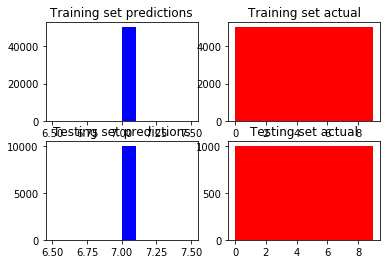

In [186]:
Y_train_pred = cifar10_net.forward(X_train).detach().cpu().argmax(axis=1)
Y_test_pred = cifar10_net.forward(X_test).detach().cpu().argmax(axis=1)
show_performance(Y_train, Y_train_pred, Y_test, Y_test_pred)

In [108]:
cifar10_net.fit(X_train, Y_train, epochs=5)









  0%|          | 0/1563 [00:00<?, ?it/s]







  0%|          | 3/1563 [00:00<00:52, 29.62it/s]

Epoch 0
--------------------------------










  0%|          | 5/1563 [00:00<01:00, 25.85it/s]







  1%|          | 8/1563 [00:00<00:59, 26.30it/s]







  1%|          | 13/1563 [00:00<00:51, 30.37it/s]







  1%|          | 19/1563 [00:00<00:43, 35.37it/s]







  2%|▏         | 25/1563 [00:00<00:38, 39.47it/s]







  2%|▏         | 31/1563 [00:00<00:35, 43.08it/s]







  2%|▏         | 37/1563 [00:00<00:32, 46.48it/s]







  3%|▎         | 44/1563 [00:00<00:30, 50.28it/s]







  3%|▎         | 50/1563 [00:01<00:30, 49.72it/s]







  4%|▎         | 56/1563 [00:01<00:30, 49.36it/s]







  4%|▍         | 62/1563 [00:01<00:30, 48.52it/s]







  4%|▍         | 67/1563 [00:01<00:31, 48.16it/s]







  5%|▍         | 72/1563 [00:01<00:31, 47.20it/s]







  5%|▌         | 79/1563 [00:01<00:29, 50.99it/s]







  5%|▌         | 85/1563 [00:01<00:27, 53.24it/s]







  6%|▌         | 91/1563 [00:01<00:27, 54.08it/s]







  6%|▌         | 97/1563 [00:01<00:26, 54.85it/s]







  7%|▋         | 103/1563

100 Batch Loss: 225.44589948654175










  7%|▋         | 115/1563 [00:02<00:26, 55.51it/s]







  8%|▊         | 123/1563 [00:02<00:24, 59.79it/s]







  8%|▊         | 130/1563 [00:02<00:23, 61.90it/s]







  9%|▉         | 137/1563 [00:02<00:22, 63.24it/s]







  9%|▉         | 144/1563 [00:02<00:23, 60.81it/s]







 10%|▉         | 151/1563 [00:02<00:22, 62.10it/s]







 10%|█         | 158/1563 [00:02<00:22, 62.31it/s]







 11%|█         | 165/1563 [00:03<00:22, 63.14it/s]







 11%|█         | 172/1563 [00:03<00:21, 64.11it/s]







 11%|█▏        | 179/1563 [00:03<00:21, 65.12it/s]







 12%|█▏        | 186/1563 [00:03<00:21, 65.36it/s]







 12%|█▏        | 193/1563 [00:03<00:21, 65.01it/s]







 13%|█▎        | 200/1563 [00:03<00:21, 64.27it/s]







 13%|█▎        | 207/1563 [00:03<00:22, 59.95it/s]

100 Batch Loss: 221.1043996810913










 14%|█▎        | 214/1563 [00:03<00:22, 59.14it/s]







 14%|█▍        | 221/1563 [00:03<00:22, 59.90it/s]







 15%|█▍        | 228/1563 [00:04<00:21, 61.09it/s]







 15%|█▌        | 235/1563 [00:04<00:21, 62.52it/s]







 15%|█▌        | 242/1563 [00:04<00:21, 61.23it/s]







 16%|█▌        | 249/1563 [00:04<00:21, 60.78it/s]







 16%|█▋        | 256/1563 [00:04<00:22, 58.23it/s]







 17%|█▋        | 263/1563 [00:04<00:21, 59.76it/s]







 17%|█▋        | 270/1563 [00:04<00:21, 60.12it/s]







 18%|█▊        | 277/1563 [00:04<00:21, 59.50it/s]







 18%|█▊        | 283/1563 [00:05<00:24, 52.93it/s]







 19%|█▊        | 290/1563 [00:05<00:22, 55.95it/s]







 19%|█▉        | 297/1563 [00:05<00:21, 57.78it/s]







 19%|█▉        | 303/1563 [00:05<00:21, 57.98it/s]







 20%|█▉        | 309/1563 [00:05<00:21, 58.46it/s]

100 Batch Loss: 221.4635100364685










 20%|██        | 315/1563 [00:05<00:23, 52.85it/s]







 21%|██        | 322/1563 [00:05<00:22, 55.69it/s]







 21%|██        | 329/1563 [00:05<00:21, 58.31it/s]







 21%|██▏       | 336/1563 [00:05<00:20, 60.17it/s]







 22%|██▏       | 343/1563 [00:06<00:20, 60.71it/s]







 22%|██▏       | 350/1563 [00:06<00:19, 61.93it/s]







 23%|██▎       | 357/1563 [00:06<00:19, 62.36it/s]







 23%|██▎       | 364/1563 [00:06<00:19, 62.55it/s]







 24%|██▎       | 371/1563 [00:06<00:18, 63.45it/s]







 24%|██▍       | 378/1563 [00:06<00:18, 62.46it/s]







 25%|██▍       | 385/1563 [00:06<00:18, 62.49it/s]







 25%|██▌       | 392/1563 [00:06<00:18, 62.92it/s]







 26%|██▌       | 399/1563 [00:06<00:18, 63.26it/s]







 26%|██▌       | 406/1563 [00:07<00:18, 63.74it/s]







 26%|██▋       | 413/1563 [00:07<00:17, 64.30it/s]

100 Batch Loss: 218.878999710083










 27%|██▋       | 420/1563 [00:07<00:17, 63.67it/s]







 27%|██▋       | 427/1563 [00:07<00:18, 62.93it/s]







 28%|██▊       | 434/1563 [00:07<00:17, 63.14it/s]







 28%|██▊       | 441/1563 [00:07<00:17, 63.52it/s]







 29%|██▊       | 448/1563 [00:07<00:17, 63.66it/s]







 29%|██▉       | 455/1563 [00:07<00:17, 63.70it/s]







 30%|██▉       | 462/1563 [00:07<00:17, 61.59it/s]







 30%|███       | 469/1563 [00:08<00:17, 62.32it/s]







 30%|███       | 476/1563 [00:08<00:17, 62.08it/s]







 31%|███       | 483/1563 [00:08<00:17, 62.62it/s]







 31%|███▏      | 490/1563 [00:08<00:17, 62.75it/s]







 32%|███▏      | 497/1563 [00:08<00:17, 59.74it/s]







 32%|███▏      | 504/1563 [00:08<00:17, 60.69it/s]







 33%|███▎      | 511/1563 [00:08<00:16, 62.38it/s]

100 Batch Loss: 220.08016848564148










 33%|███▎      | 518/1563 [00:08<00:16, 61.53it/s]







 34%|███▎      | 525/1563 [00:08<00:16, 61.13it/s]







 34%|███▍      | 532/1563 [00:09<00:16, 61.01it/s]







 34%|███▍      | 539/1563 [00:09<00:16, 61.89it/s]







 35%|███▍      | 546/1563 [00:09<00:16, 62.26it/s]







 35%|███▌      | 553/1563 [00:09<00:15, 63.94it/s]







 36%|███▌      | 560/1563 [00:09<00:15, 64.59it/s]







 36%|███▋      | 567/1563 [00:09<00:15, 64.53it/s]







 37%|███▋      | 574/1563 [00:09<00:15, 64.30it/s]







 37%|███▋      | 581/1563 [00:09<00:15, 64.47it/s]







 38%|███▊      | 588/1563 [00:09<00:15, 64.55it/s]







 38%|███▊      | 595/1563 [00:10<00:15, 64.18it/s]







 39%|███▊      | 602/1563 [00:10<00:15, 62.42it/s]







 39%|███▉      | 609/1563 [00:10<00:15, 63.48it/s]

100 Batch Loss: 219.5808641910553










 39%|███▉      | 616/1563 [00:10<00:14, 64.61it/s]







 40%|███▉      | 623/1563 [00:10<00:14, 66.07it/s]







 40%|████      | 630/1563 [00:10<00:13, 66.81it/s]







 41%|████      | 637/1563 [00:10<00:13, 66.80it/s]







 41%|████      | 644/1563 [00:10<00:13, 66.59it/s]







 42%|████▏     | 651/1563 [00:10<00:13, 65.70it/s]







 42%|████▏     | 658/1563 [00:11<00:13, 65.68it/s]







 43%|████▎     | 665/1563 [00:11<00:13, 65.33it/s]







 43%|████▎     | 672/1563 [00:11<00:13, 65.98it/s]







 43%|████▎     | 679/1563 [00:11<00:13, 66.35it/s]







 44%|████▍     | 686/1563 [00:11<00:13, 66.53it/s]







 44%|████▍     | 693/1563 [00:11<00:13, 66.38it/s]







 45%|████▍     | 700/1563 [00:11<00:13, 66.22it/s]







 45%|████▌     | 707/1563 [00:11<00:13, 65.19it/s]







 46%|████▌     | 714/1563 [00:11<00:12, 66.52it/s]

100 Batch Loss: 218.86264371871948










 46%|████▌     | 721/1563 [00:11<00:12, 65.42it/s]







 47%|████▋     | 728/1563 [00:12<00:12, 65.20it/s]







 47%|████▋     | 735/1563 [00:12<00:12, 65.35it/s]







 47%|████▋     | 742/1563 [00:12<00:12, 64.58it/s]







 48%|████▊     | 749/1563 [00:12<00:12, 64.95it/s]







 48%|████▊     | 756/1563 [00:12<00:12, 64.47it/s]







 49%|████▉     | 763/1563 [00:12<00:12, 64.67it/s]







 49%|████▉     | 770/1563 [00:12<00:12, 64.76it/s]







 50%|████▉     | 777/1563 [00:12<00:12, 64.28it/s]







 50%|█████     | 784/1563 [00:12<00:12, 64.07it/s]







 51%|█████     | 791/1563 [00:13<00:12, 63.80it/s]







 51%|█████     | 798/1563 [00:13<00:11, 65.11it/s]







 52%|█████▏    | 805/1563 [00:13<00:12, 62.13it/s]







 52%|█████▏    | 812/1563 [00:13<00:12, 62.10it/s]

100 Batch Loss: 218.74396896362305










 52%|█████▏    | 819/1563 [00:13<00:11, 62.59it/s]







 53%|█████▎    | 826/1563 [00:13<00:11, 63.43it/s]







 53%|█████▎    | 833/1563 [00:13<00:11, 64.92it/s]







 54%|█████▎    | 840/1563 [00:13<00:11, 65.00it/s]







 54%|█████▍    | 847/1563 [00:13<00:10, 65.64it/s]







 55%|█████▍    | 854/1563 [00:14<00:10, 65.06it/s]







 55%|█████▌    | 861/1563 [00:14<00:10, 64.09it/s]







 56%|█████▌    | 868/1563 [00:14<00:10, 64.51it/s]







 56%|█████▌    | 875/1563 [00:14<00:10, 65.05it/s]







 56%|█████▋    | 882/1563 [00:14<00:10, 65.53it/s]







 57%|█████▋    | 889/1563 [00:14<00:10, 64.98it/s]







 57%|█████▋    | 896/1563 [00:14<00:10, 64.65it/s]







 58%|█████▊    | 903/1563 [00:14<00:10, 65.10it/s]







 58%|█████▊    | 910/1563 [00:14<00:09, 66.09it/s]

100 Batch Loss: 217.5788745880127










 59%|█████▊    | 917/1563 [00:15<00:10, 64.37it/s]







 59%|█████▉    | 924/1563 [00:15<00:09, 64.48it/s]







 60%|█████▉    | 931/1563 [00:15<00:09, 65.00it/s]







 60%|██████    | 938/1563 [00:15<00:09, 64.76it/s]







 60%|██████    | 945/1563 [00:15<00:09, 65.14it/s]







 61%|██████    | 952/1563 [00:15<00:09, 65.50it/s]







 61%|██████▏   | 959/1563 [00:15<00:09, 66.01it/s]







 62%|██████▏   | 966/1563 [00:15<00:09, 65.27it/s]







 62%|██████▏   | 973/1563 [00:15<00:09, 64.31it/s]







 63%|██████▎   | 980/1563 [00:15<00:09, 64.73it/s]







 63%|██████▎   | 987/1563 [00:16<00:08, 64.54it/s]







 64%|██████▎   | 994/1563 [00:16<00:08, 64.28it/s]







 64%|██████▍   | 1001/1563 [00:16<00:08, 65.38it/s]







 64%|██████▍   | 1008/1563 [00:16<00:08, 65.75it/s]

100 Batch Loss: 215.6141881942749










 65%|██████▍   | 1015/1563 [00:16<00:08, 65.94it/s]







 65%|██████▌   | 1022/1563 [00:16<00:08, 66.07it/s]







 66%|██████▌   | 1029/1563 [00:16<00:08, 66.44it/s]







 66%|██████▋   | 1036/1563 [00:16<00:07, 66.88it/s]







 67%|██████▋   | 1043/1563 [00:16<00:07, 66.41it/s]







 67%|██████▋   | 1050/1563 [00:17<00:07, 66.33it/s]







 68%|██████▊   | 1057/1563 [00:17<00:07, 66.20it/s]







 68%|██████▊   | 1064/1563 [00:17<00:07, 66.02it/s]







 69%|██████▊   | 1071/1563 [00:17<00:07, 65.60it/s]







 69%|██████▉   | 1078/1563 [00:17<00:07, 65.12it/s]







 69%|██████▉   | 1085/1563 [00:17<00:07, 65.37it/s]







 70%|██████▉   | 1092/1563 [00:17<00:07, 65.15it/s]







 70%|███████   | 1099/1563 [00:17<00:06, 66.47it/s]







 71%|███████   | 1106/1563 [00:17<00:06, 65.70it/s]







 71%|███████   | 1113/1563 [00:17<00:06, 64.91it/s]

100 Batch Loss: 216.7564787864685










 72%|███████▏  | 1120/1563 [00:18<00:06, 63.88it/s]







 72%|███████▏  | 1127/1563 [00:18<00:06, 65.26it/s]







 73%|███████▎  | 1134/1563 [00:18<00:06, 66.24it/s]







 73%|███████▎  | 1141/1563 [00:18<00:06, 66.01it/s]







 73%|███████▎  | 1148/1563 [00:18<00:06, 65.89it/s]







 74%|███████▍  | 1155/1563 [00:18<00:06, 66.87it/s]







 74%|███████▍  | 1162/1563 [00:18<00:05, 67.71it/s]







 75%|███████▍  | 1169/1563 [00:18<00:05, 66.79it/s]







 75%|███████▌  | 1176/1563 [00:18<00:06, 62.39it/s]







 76%|███████▌  | 1183/1563 [00:19<00:06, 63.30it/s]







 76%|███████▌  | 1190/1563 [00:19<00:05, 63.62it/s]







 77%|███████▋  | 1197/1563 [00:19<00:05, 63.57it/s]







 77%|███████▋  | 1204/1563 [00:19<00:05, 63.49it/s]







 77%|███████▋  | 1211/1563 [00:19<00:05, 64.21it/s]

100 Batch Loss: 215.85682833194733










 78%|███████▊  | 1218/1563 [00:19<00:05, 62.60it/s]







 78%|███████▊  | 1225/1563 [00:19<00:05, 61.63it/s]







 79%|███████▉  | 1232/1563 [00:19<00:05, 63.42it/s]







 79%|███████▉  | 1239/1563 [00:19<00:05, 64.04it/s]







 80%|███████▉  | 1246/1563 [00:20<00:04, 64.52it/s]







 80%|████████  | 1253/1563 [00:20<00:04, 64.45it/s]







 81%|████████  | 1260/1563 [00:20<00:04, 64.74it/s]







 81%|████████  | 1267/1563 [00:20<00:04, 64.96it/s]







 82%|████████▏ | 1274/1563 [00:20<00:04, 62.07it/s]







 82%|████████▏ | 1281/1563 [00:20<00:04, 62.49it/s]







 82%|████████▏ | 1288/1563 [00:20<00:04, 59.42it/s]







 83%|████████▎ | 1295/1563 [00:20<00:04, 61.26it/s]







 83%|████████▎ | 1302/1563 [00:20<00:04, 62.03it/s]







 84%|████████▎ | 1309/1563 [00:21<00:04, 62.83it/s]

100 Batch Loss: 213.61234605312347










 84%|████████▍ | 1316/1563 [00:21<00:03, 62.26it/s]







 85%|████████▍ | 1324/1563 [00:21<00:03, 64.46it/s]







 85%|████████▌ | 1331/1563 [00:21<00:03, 64.43it/s]







 86%|████████▌ | 1338/1563 [00:21<00:03, 64.94it/s]







 86%|████████▌ | 1345/1563 [00:21<00:03, 65.75it/s]







 87%|████████▋ | 1352/1563 [00:21<00:03, 65.80it/s]







 87%|████████▋ | 1359/1563 [00:21<00:03, 66.04it/s]







 87%|████████▋ | 1366/1563 [00:21<00:03, 65.51it/s]







 88%|████████▊ | 1373/1563 [00:22<00:02, 65.06it/s]







 88%|████████▊ | 1380/1563 [00:22<00:02, 64.67it/s]







 89%|████████▊ | 1387/1563 [00:22<00:02, 64.88it/s]







 89%|████████▉ | 1394/1563 [00:22<00:02, 65.25it/s]







 90%|████████▉ | 1401/1563 [00:22<00:02, 65.36it/s]







 90%|█████████ | 1408/1563 [00:22<00:02, 65.54it/s]

100 Batch Loss: 213.91941440105438










 91%|█████████ | 1415/1563 [00:22<00:02, 64.72it/s]







 91%|█████████ | 1422/1563 [00:22<00:02, 63.60it/s]







 91%|█████████▏| 1429/1563 [00:22<00:02, 63.94it/s]







 92%|█████████▏| 1436/1563 [00:23<00:01, 64.55it/s]







 92%|█████████▏| 1443/1563 [00:23<00:01, 64.96it/s]







 93%|█████████▎| 1450/1563 [00:23<00:01, 65.69it/s]







 93%|█████████▎| 1457/1563 [00:23<00:01, 65.07it/s]







 94%|█████████▎| 1464/1563 [00:23<00:01, 65.19it/s]







 94%|█████████▍| 1471/1563 [00:23<00:01, 66.05it/s]







 95%|█████████▍| 1478/1563 [00:23<00:01, 65.81it/s]







 95%|█████████▌| 1485/1563 [00:23<00:01, 65.97it/s]







 95%|█████████▌| 1492/1563 [00:23<00:01, 65.80it/s]







 96%|█████████▌| 1499/1563 [00:23<00:00, 64.91it/s]







 96%|█████████▋| 1506/1563 [00:24<00:00, 63.65it/s]







 97%|█████████▋| 1513/1563 [00:24<00:00, 62.63it/s]

100 Batch Loss: 212.45667052268982










 97%|█████████▋| 1520/1563 [00:24<00:00, 58.96it/s]







 98%|█████████▊| 1527/1563 [00:24<00:00, 60.79it/s]







 98%|█████████▊| 1534/1563 [00:24<00:00, 62.06it/s]







 99%|█████████▊| 1541/1563 [00:24<00:00, 63.35it/s]







 99%|█████████▉| 1548/1563 [00:24<00:00, 63.87it/s]







 99%|█████████▉| 1555/1563 [00:24<00:00, 63.87it/s]







100%|██████████| 1563/1563 [00:25<00:00, 62.51it/s]








  0%|          | 0/1563 [00:00<?, ?it/s]







  0%|          | 7/1563 [00:00<00:24, 63.60it/s]

Epoch 1
--------------------------------










  1%|          | 14/1563 [00:00<00:24, 62.89it/s]







  1%|▏         | 21/1563 [00:00<00:24, 64.04it/s]







  2%|▏         | 28/1563 [00:00<00:23, 64.65it/s]







  2%|▏         | 35/1563 [00:00<00:23, 64.85it/s]







  3%|▎         | 42/1563 [00:00<00:23, 65.03it/s]







  3%|▎         | 49/1563 [00:00<00:23, 65.09it/s]







  4%|▎         | 55/1563 [00:00<00:24, 62.68it/s]







  4%|▍         | 61/1563 [00:00<00:25, 58.76it/s]







  4%|▍         | 68/1563 [00:01<00:24, 61.12it/s]







  5%|▍         | 75/1563 [00:01<00:23, 62.89it/s]







  5%|▌         | 82/1563 [00:01<00:23, 63.31it/s]







  6%|▌         | 89/1563 [00:01<00:23, 63.79it/s]







  6%|▌         | 96/1563 [00:01<00:22, 64.12it/s]







  7%|▋         | 103/1563 [00:01<00:22, 64.83it/s]







  7%|▋         | 110/1563 [00:01<00:21, 66.11it/s]

100 Batch Loss: 213.28704226016998










  7%|▋         | 117/1563 [00:01<00:22, 65.08it/s]







  8%|▊         | 124/1563 [00:01<00:22, 64.50it/s]







  8%|▊         | 131/1563 [00:02<00:21, 65.59it/s]







  9%|▉         | 138/1563 [00:02<00:21, 65.21it/s]







  9%|▉         | 146/1563 [00:02<00:21, 66.81it/s]







 10%|▉         | 153/1563 [00:02<00:20, 67.66it/s]







 10%|█         | 160/1563 [00:02<00:20, 67.38it/s]







 11%|█         | 167/1563 [00:02<00:20, 67.46it/s]







 11%|█         | 174/1563 [00:02<00:20, 66.67it/s]







 12%|█▏        | 181/1563 [00:02<00:20, 65.85it/s]







 12%|█▏        | 188/1563 [00:02<00:21, 65.37it/s]







 12%|█▏        | 195/1563 [00:03<00:20, 65.28it/s]







 13%|█▎        | 202/1563 [00:03<00:20, 65.24it/s]







 13%|█▎        | 209/1563 [00:03<00:20, 65.20it/s]

100 Batch Loss: 209.65993189811707










 14%|█▍        | 216/1563 [00:03<00:21, 61.50it/s]







 14%|█▍        | 223/1563 [00:03<00:21, 61.06it/s]







 15%|█▍        | 230/1563 [00:03<00:21, 62.17it/s]







 15%|█▌        | 237/1563 [00:03<00:21, 62.91it/s]







 16%|█▌        | 244/1563 [00:03<00:20, 63.90it/s]







 16%|█▌        | 251/1563 [00:03<00:20, 63.52it/s]







 17%|█▋        | 258/1563 [00:04<00:20, 62.59it/s]







 17%|█▋        | 265/1563 [00:04<00:20, 63.36it/s]







 17%|█▋        | 272/1563 [00:04<00:20, 63.29it/s]







 18%|█▊        | 279/1563 [00:04<00:19, 64.65it/s]







 18%|█▊        | 286/1563 [00:04<00:19, 65.86it/s]







 19%|█▊        | 293/1563 [00:04<00:19, 65.66it/s]







 19%|█▉        | 300/1563 [00:04<00:19, 66.09it/s]







 20%|█▉        | 307/1563 [00:04<00:18, 66.15it/s]







 20%|██        | 314/1563 [00:04<00:18, 66.01it/s]

100 Batch Loss: 211.46059262752533










 21%|██        | 321/1563 [00:04<00:19, 64.64it/s]







 21%|██        | 328/1563 [00:05<00:19, 64.93it/s]







 21%|██▏       | 335/1563 [00:05<00:18, 64.96it/s]







 22%|██▏       | 342/1563 [00:05<00:18, 65.12it/s]







 22%|██▏       | 349/1563 [00:05<00:18, 65.98it/s]







 23%|██▎       | 356/1563 [00:05<00:18, 65.90it/s]







 23%|██▎       | 363/1563 [00:05<00:18, 65.52it/s]







 24%|██▎       | 370/1563 [00:05<00:18, 66.03it/s]







 24%|██▍       | 377/1563 [00:05<00:17, 65.97it/s]







 25%|██▍       | 384/1563 [00:05<00:17, 66.67it/s]







 25%|██▌       | 391/1563 [00:06<00:17, 65.26it/s]







 25%|██▌       | 398/1563 [00:06<00:17, 65.05it/s]







 26%|██▌       | 405/1563 [00:06<00:18, 62.19it/s]







 26%|██▋       | 412/1563 [00:06<00:18, 62.90it/s]

100 Batch Loss: 211.111354470253










 27%|██▋       | 419/1563 [00:06<00:19, 59.06it/s]







 27%|██▋       | 426/1563 [00:06<00:18, 60.68it/s]







 28%|██▊       | 434/1563 [00:06<00:17, 63.44it/s]







 28%|██▊       | 441/1563 [00:06<00:17, 64.15it/s]







 29%|██▊       | 448/1563 [00:06<00:17, 64.59it/s]







 29%|██▉       | 455/1563 [00:07<00:17, 64.57it/s]







 30%|██▉       | 462/1563 [00:07<00:16, 65.38it/s]







 30%|███       | 469/1563 [00:07<00:16, 64.98it/s]







 30%|███       | 476/1563 [00:07<00:16, 64.89it/s]







 31%|███       | 483/1563 [00:07<00:16, 64.91it/s]







 31%|███▏      | 490/1563 [00:07<00:16, 64.02it/s]







 32%|███▏      | 498/1563 [00:07<00:16, 66.00it/s]







 32%|███▏      | 505/1563 [00:07<00:16, 64.29it/s]







 33%|███▎      | 512/1563 [00:07<00:16, 64.72it/s]

100 Batch Loss: 209.63632547855377










 33%|███▎      | 519/1563 [00:08<00:16, 64.57it/s]







 34%|███▎      | 526/1563 [00:08<00:16, 64.54it/s]







 34%|███▍      | 533/1563 [00:08<00:15, 65.33it/s]







 35%|███▍      | 540/1563 [00:08<00:15, 65.38it/s]







 35%|███▍      | 547/1563 [00:08<00:16, 62.22it/s]







 35%|███▌      | 554/1563 [00:08<00:16, 62.53it/s]







 36%|███▌      | 561/1563 [00:08<00:15, 62.69it/s]







 36%|███▋      | 568/1563 [00:08<00:15, 63.82it/s]







 37%|███▋      | 575/1563 [00:08<00:15, 63.88it/s]







 37%|███▋      | 582/1563 [00:09<00:15, 63.58it/s]







 38%|███▊      | 589/1563 [00:09<00:15, 63.25it/s]







 38%|███▊      | 596/1563 [00:09<00:15, 64.23it/s]







 39%|███▊      | 603/1563 [00:09<00:14, 64.50it/s]







 39%|███▉      | 610/1563 [00:09<00:14, 65.12it/s]

100 Batch Loss: 208.98981082439423










 39%|███▉      | 617/1563 [00:09<00:14, 64.07it/s]







 40%|███▉      | 624/1563 [00:09<00:14, 63.17it/s]







 40%|████      | 631/1563 [00:09<00:15, 60.27it/s]







 41%|████      | 638/1563 [00:09<00:14, 61.87it/s]







 41%|████▏     | 645/1563 [00:10<00:14, 62.41it/s]







 42%|████▏     | 652/1563 [00:10<00:14, 63.32it/s]







 42%|████▏     | 659/1563 [00:10<00:14, 63.87it/s]







 43%|████▎     | 666/1563 [00:10<00:13, 64.94it/s]







 43%|████▎     | 673/1563 [00:10<00:13, 65.00it/s]







 44%|████▎     | 680/1563 [00:10<00:13, 64.49it/s]







 44%|████▍     | 687/1563 [00:10<00:13, 64.85it/s]







 44%|████▍     | 694/1563 [00:10<00:13, 65.33it/s]







 45%|████▍     | 701/1563 [00:10<00:13, 64.45it/s]







 45%|████▌     | 708/1563 [00:10<00:12, 65.77it/s]

100 Batch Loss: 207.80870401859283










 46%|████▌     | 715/1563 [00:11<00:13, 65.01it/s]







 46%|████▌     | 722/1563 [00:11<00:13, 63.36it/s]







 47%|████▋     | 729/1563 [00:11<00:13, 63.25it/s]







 47%|████▋     | 736/1563 [00:11<00:12, 63.72it/s]







 48%|████▊     | 743/1563 [00:11<00:12, 64.79it/s]







 48%|████▊     | 750/1563 [00:11<00:12, 65.53it/s]







 48%|████▊     | 757/1563 [00:11<00:12, 65.35it/s]







 49%|████▉     | 764/1563 [00:11<00:12, 64.38it/s]







 49%|████▉     | 771/1563 [00:11<00:12, 65.93it/s]







 50%|████▉     | 778/1563 [00:12<00:11, 66.39it/s]







 50%|█████     | 785/1563 [00:12<00:11, 66.24it/s]







 51%|█████     | 792/1563 [00:12<00:11, 65.72it/s]







 51%|█████     | 799/1563 [00:12<00:11, 65.88it/s]







 52%|█████▏    | 806/1563 [00:12<00:11, 65.35it/s]







 52%|█████▏    | 813/1563 [00:12<00:11, 66.11it/s]

100 Batch Loss: 209.1606752872467










 52%|█████▏    | 820/1563 [00:12<00:11, 64.14it/s]







 53%|█████▎    | 827/1563 [00:12<00:11, 65.41it/s]







 53%|█████▎    | 834/1563 [00:12<00:10, 66.33it/s]







 54%|█████▍    | 841/1563 [00:13<00:10, 67.05it/s]







 54%|█████▍    | 848/1563 [00:13<00:10, 66.95it/s]







 55%|█████▍    | 855/1563 [00:13<00:10, 66.04it/s]







 55%|█████▌    | 862/1563 [00:13<00:10, 65.08it/s]







 56%|█████▌    | 869/1563 [00:13<00:10, 65.59it/s]







 56%|█████▌    | 876/1563 [00:13<00:10, 65.78it/s]







 56%|█████▋    | 883/1563 [00:13<00:10, 66.05it/s]







 57%|█████▋    | 890/1563 [00:13<00:10, 66.93it/s]







 57%|█████▋    | 897/1563 [00:13<00:10, 66.43it/s]







 58%|█████▊    | 904/1563 [00:13<00:09, 66.00it/s]







 58%|█████▊    | 911/1563 [00:14<00:09, 66.07it/s]

100 Batch Loss: 209.21376860141754










 59%|█████▊    | 918/1563 [00:14<00:09, 65.28it/s]







 59%|█████▉    | 925/1563 [00:14<00:09, 66.37it/s]







 60%|█████▉    | 932/1563 [00:14<00:09, 66.95it/s]







 60%|██████    | 939/1563 [00:14<00:09, 65.93it/s]







 61%|██████    | 946/1563 [00:14<00:09, 66.61it/s]







 61%|██████    | 953/1563 [00:14<00:09, 65.25it/s]







 61%|██████▏   | 960/1563 [00:14<00:09, 65.03it/s]







 62%|██████▏   | 967/1563 [00:14<00:09, 65.10it/s]







 62%|██████▏   | 974/1563 [00:15<00:09, 64.74it/s]







 63%|██████▎   | 981/1563 [00:15<00:09, 63.31it/s]







 63%|██████▎   | 988/1563 [00:15<00:08, 64.09it/s]







 64%|██████▎   | 995/1563 [00:15<00:08, 64.85it/s]







 64%|██████▍   | 1002/1563 [00:15<00:08, 64.96it/s]







 65%|██████▍   | 1009/1563 [00:15<00:08, 65.06it/s]

100 Batch Loss: 206.72727859020233










 65%|██████▌   | 1016/1563 [00:15<00:08, 63.30it/s]







 65%|██████▌   | 1023/1563 [00:15<00:08, 61.32it/s]







 66%|██████▌   | 1030/1563 [00:15<00:08, 61.36it/s]







 66%|██████▋   | 1037/1563 [00:16<00:08, 62.20it/s]







 67%|██████▋   | 1044/1563 [00:16<00:08, 59.13it/s]







 67%|██████▋   | 1050/1563 [00:16<00:08, 57.21it/s]







 68%|██████▊   | 1056/1563 [00:16<00:09, 55.65it/s]







 68%|██████▊   | 1062/1563 [00:16<00:08, 56.35it/s]







 68%|██████▊   | 1068/1563 [00:16<00:08, 56.23it/s]







 69%|██████▊   | 1074/1563 [00:16<00:08, 55.32it/s]







 69%|██████▉   | 1080/1563 [00:16<00:08, 55.53it/s]







 69%|██████▉   | 1086/1563 [00:16<00:08, 55.95it/s]







 70%|██████▉   | 1092/1563 [00:17<00:08, 56.80it/s]







 70%|███████   | 1098/1563 [00:17<00:08, 57.46it/s]







 71%|███████   | 1104/1563 [00:17<00:07, 58.05it/s]







 71%|███████   | 1110/1563 [00:17<00:07, 57.32it/s]

100 Batch Loss: 207.85755038261414










 71%|███████▏  | 1116/1563 [00:17<00:07, 57.58it/s]







 72%|███████▏  | 1122/1563 [00:17<00:08, 54.48it/s]







 72%|███████▏  | 1129/1563 [00:17<00:07, 56.83it/s]







 73%|███████▎  | 1135/1563 [00:17<00:07, 56.96it/s]







 73%|███████▎  | 1142/1563 [00:17<00:07, 58.29it/s]







 73%|███████▎  | 1148/1563 [00:18<00:07, 56.67it/s]







 74%|███████▍  | 1154/1563 [00:18<00:07, 57.07it/s]







 74%|███████▍  | 1160/1563 [00:18<00:07, 57.43it/s]







 75%|███████▍  | 1167/1563 [00:18<00:06, 59.13it/s]







 75%|███████▌  | 1174/1563 [00:18<00:06, 61.37it/s]







 76%|███████▌  | 1181/1563 [00:18<00:06, 62.47it/s]







 76%|███████▌  | 1188/1563 [00:18<00:05, 64.05it/s]







 76%|███████▋  | 1195/1563 [00:18<00:05, 65.22it/s]







 77%|███████▋  | 1202/1563 [00:18<00:05, 65.70it/s]







 77%|███████▋  | 1209/1563 [00:18<00:05, 65.55it/s]

100 Batch Loss: 205.82417106628418










 78%|███████▊  | 1216/1563 [00:19<00:05, 64.58it/s]







 78%|███████▊  | 1223/1563 [00:19<00:05, 63.76it/s]







 79%|███████▊  | 1230/1563 [00:19<00:05, 63.77it/s]







 79%|███████▉  | 1237/1563 [00:19<00:05, 64.74it/s]







 80%|███████▉  | 1244/1563 [00:19<00:04, 64.71it/s]







 80%|████████  | 1251/1563 [00:19<00:04, 64.95it/s]







 80%|████████  | 1258/1563 [00:19<00:04, 64.72it/s]







 81%|████████  | 1265/1563 [00:19<00:04, 64.26it/s]







 81%|████████▏ | 1272/1563 [00:19<00:04, 63.92it/s]







 82%|████████▏ | 1279/1563 [00:20<00:04, 64.87it/s]







 82%|████████▏ | 1286/1563 [00:20<00:04, 63.93it/s]







 83%|████████▎ | 1293/1563 [00:20<00:04, 65.14it/s]







 83%|████████▎ | 1300/1563 [00:20<00:03, 66.22it/s]







 84%|████████▎ | 1307/1563 [00:20<00:03, 66.15it/s]







 84%|████████▍ | 1314/1563 [00:20<00:03, 65.80it/s]

100 Batch Loss: 206.64561939239502










 85%|████████▍ | 1321/1563 [00:20<00:03, 65.07it/s]







 85%|████████▍ | 1328/1563 [00:20<00:03, 64.20it/s]







 85%|████████▌ | 1335/1563 [00:20<00:03, 64.05it/s]







 86%|████████▌ | 1343/1563 [00:21<00:03, 66.21it/s]







 86%|████████▋ | 1350/1563 [00:21<00:03, 67.21it/s]







 87%|████████▋ | 1357/1563 [00:21<00:03, 66.70it/s]







 87%|████████▋ | 1364/1563 [00:21<00:03, 65.23it/s]







 88%|████████▊ | 1371/1563 [00:21<00:02, 65.36it/s]







 88%|████████▊ | 1378/1563 [00:21<00:02, 66.49it/s]







 89%|████████▊ | 1385/1563 [00:21<00:02, 65.62it/s]







 89%|████████▉ | 1392/1563 [00:21<00:02, 65.28it/s]







 90%|████████▉ | 1399/1563 [00:21<00:02, 63.64it/s]







 90%|████████▉ | 1406/1563 [00:22<00:02, 63.02it/s]







 90%|█████████ | 1413/1563 [00:22<00:02, 64.37it/s]

100 Batch Loss: 206.73024427890778










 91%|█████████ | 1420/1563 [00:22<00:02, 63.16it/s]







 91%|█████████▏| 1427/1563 [00:22<00:02, 63.87it/s]







 92%|█████████▏| 1434/1563 [00:22<00:01, 64.75it/s]







 92%|█████████▏| 1441/1563 [00:22<00:01, 65.71it/s]







 93%|█████████▎| 1448/1563 [00:22<00:01, 66.42it/s]







 93%|█████████▎| 1455/1563 [00:22<00:01, 65.95it/s]







 94%|█████████▎| 1462/1563 [00:22<00:01, 64.05it/s]







 94%|█████████▍| 1469/1563 [00:22<00:01, 64.31it/s]







 94%|█████████▍| 1476/1563 [00:23<00:01, 64.80it/s]







 95%|█████████▍| 1483/1563 [00:23<00:01, 64.19it/s]







 95%|█████████▌| 1490/1563 [00:23<00:01, 62.14it/s]







 96%|█████████▌| 1497/1563 [00:23<00:01, 63.16it/s]







 96%|█████████▌| 1504/1563 [00:23<00:00, 63.61it/s]







 97%|█████████▋| 1511/1563 [00:23<00:00, 63.36it/s]

100 Batch Loss: 206.9152615070343










 97%|█████████▋| 1518/1563 [00:23<00:00, 62.44it/s]







 98%|█████████▊| 1525/1563 [00:23<00:00, 63.56it/s]







 98%|█████████▊| 1532/1563 [00:23<00:00, 64.34it/s]







 98%|█████████▊| 1539/1563 [00:24<00:00, 64.42it/s]







 99%|█████████▉| 1546/1563 [00:24<00:00, 65.17it/s]







 99%|█████████▉| 1553/1563 [00:24<00:00, 64.66it/s]







100%|██████████| 1563/1563 [00:24<00:00, 63.90it/s]








  0%|          | 0/1563 [00:00<?, ?it/s]







  0%|          | 7/1563 [00:00<00:23, 66.80it/s]

Epoch 2
--------------------------------










  1%|          | 14/1563 [00:00<00:23, 66.01it/s]







  1%|▏         | 21/1563 [00:00<00:23, 65.82it/s]







  2%|▏         | 28/1563 [00:00<00:23, 66.28it/s]







  2%|▏         | 35/1563 [00:00<00:22, 66.45it/s]







  3%|▎         | 41/1563 [00:00<00:23, 63.55it/s]







  3%|▎         | 48/1563 [00:00<00:23, 64.88it/s]







  4%|▎         | 55/1563 [00:00<00:23, 63.89it/s]







  4%|▍         | 62/1563 [00:00<00:22, 65.30it/s]







  4%|▍         | 69/1563 [00:01<00:22, 65.17it/s]







  5%|▍         | 76/1563 [00:01<00:22, 65.69it/s]







  5%|▌         | 83/1563 [00:01<00:22, 66.42it/s]







  6%|▌         | 90/1563 [00:01<00:22, 66.35it/s]







  6%|▌         | 97/1563 [00:01<00:22, 66.22it/s]







  7%|▋         | 104/1563 [00:01<00:22, 66.05it/s]







  7%|▋         | 111/1563 [00:01<00:22, 64.40it/s]

100 Batch Loss: 205.9234275817871










  8%|▊         | 118/1563 [00:01<00:23, 62.80it/s]







  8%|▊         | 125/1563 [00:01<00:22, 63.12it/s]







  8%|▊         | 132/1563 [00:02<00:22, 63.33it/s]







  9%|▉         | 139/1563 [00:02<00:21, 65.04it/s]







  9%|▉         | 146/1563 [00:02<00:21, 65.55it/s]







 10%|▉         | 153/1563 [00:02<00:21, 65.97it/s]







 10%|█         | 160/1563 [00:02<00:21, 66.71it/s]







 11%|█         | 167/1563 [00:02<00:20, 67.45it/s]







 11%|█         | 174/1563 [00:02<00:20, 68.08it/s]







 12%|█▏        | 181/1563 [00:02<00:20, 67.76it/s]







 12%|█▏        | 188/1563 [00:02<00:21, 65.12it/s]







 12%|█▏        | 195/1563 [00:02<00:20, 65.50it/s]







 13%|█▎        | 202/1563 [00:03<00:20, 65.94it/s]







 13%|█▎        | 209/1563 [00:03<00:22, 58.92it/s]

100 Batch Loss: 203.72541987895966










 14%|█▍        | 216/1563 [00:03<00:23, 57.05it/s]







 14%|█▍        | 223/1563 [00:03<00:22, 59.72it/s]







 15%|█▍        | 230/1563 [00:03<00:21, 60.69it/s]







 15%|█▌        | 237/1563 [00:03<00:21, 62.72it/s]







 16%|█▌        | 244/1563 [00:03<00:20, 63.58it/s]







 16%|█▌        | 251/1563 [00:03<00:20, 64.31it/s]







 17%|█▋        | 258/1563 [00:04<00:20, 64.30it/s]







 17%|█▋        | 265/1563 [00:04<00:20, 64.49it/s]







 17%|█▋        | 272/1563 [00:04<00:19, 65.35it/s]







 18%|█▊        | 279/1563 [00:04<00:19, 66.46it/s]







 18%|█▊        | 286/1563 [00:04<00:19, 65.52it/s]







 19%|█▊        | 293/1563 [00:04<00:19, 65.56it/s]







 19%|█▉        | 300/1563 [00:04<00:19, 65.68it/s]







 20%|█▉        | 307/1563 [00:04<00:19, 64.86it/s]







 20%|██        | 314/1563 [00:04<00:19, 65.55it/s]

100 Batch Loss: 206.0152726173401










 21%|██        | 321/1563 [00:04<00:18, 65.63it/s]







 21%|██        | 328/1563 [00:05<00:18, 65.34it/s]







 21%|██▏       | 335/1563 [00:05<00:18, 65.77it/s]







 22%|██▏       | 342/1563 [00:05<00:18, 65.75it/s]







 22%|██▏       | 349/1563 [00:05<00:18, 66.16it/s]







 23%|██▎       | 357/1563 [00:05<00:17, 67.38it/s]







 23%|██▎       | 364/1563 [00:05<00:17, 67.49it/s]







 24%|██▎       | 371/1563 [00:05<00:17, 66.35it/s]







 24%|██▍       | 378/1563 [00:05<00:17, 66.15it/s]







 25%|██▍       | 385/1563 [00:05<00:17, 66.51it/s]







 25%|██▌       | 392/1563 [00:06<00:17, 66.25it/s]







 26%|██▌       | 399/1563 [00:06<00:17, 65.71it/s]







 26%|██▌       | 406/1563 [00:06<00:17, 66.13it/s]







 26%|██▋       | 413/1563 [00:06<00:17, 65.96it/s]

100 Batch Loss: 205.37160086631775










 27%|██▋       | 420/1563 [00:06<00:17, 64.93it/s]







 27%|██▋       | 427/1563 [00:06<00:17, 65.70it/s]







 28%|██▊       | 434/1563 [00:06<00:17, 65.56it/s]







 28%|██▊       | 441/1563 [00:06<00:17, 65.17it/s]







 29%|██▊       | 448/1563 [00:06<00:17, 64.86it/s]







 29%|██▉       | 456/1563 [00:06<00:16, 67.13it/s]







 30%|██▉       | 463/1563 [00:07<00:16, 66.98it/s]







 30%|███       | 470/1563 [00:07<00:16, 67.03it/s]







 31%|███       | 477/1563 [00:07<00:16, 66.85it/s]







 31%|███       | 484/1563 [00:07<00:16, 66.51it/s]







 31%|███▏      | 491/1563 [00:07<00:16, 66.18it/s]







 32%|███▏      | 498/1563 [00:07<00:16, 66.32it/s]







 32%|███▏      | 505/1563 [00:07<00:15, 66.62it/s]







 33%|███▎      | 512/1563 [00:07<00:15, 66.41it/s]

100 Batch Loss: 204.7153444290161










 33%|███▎      | 519/1563 [00:07<00:16, 64.91it/s]







 34%|███▎      | 526/1563 [00:08<00:16, 64.50it/s]







 34%|███▍      | 533/1563 [00:08<00:15, 65.48it/s]







 35%|███▍      | 540/1563 [00:08<00:15, 65.17it/s]







 35%|███▍      | 547/1563 [00:08<00:15, 64.28it/s]







 35%|███▌      | 554/1563 [00:08<00:15, 64.11it/s]







 36%|███▌      | 561/1563 [00:08<00:15, 64.48it/s]







 36%|███▋      | 568/1563 [00:08<00:15, 64.94it/s]







 37%|███▋      | 575/1563 [00:08<00:14, 66.08it/s]







 37%|███▋      | 582/1563 [00:08<00:14, 65.44it/s]







 38%|███▊      | 589/1563 [00:09<00:14, 65.12it/s]







 38%|███▊      | 596/1563 [00:09<00:14, 65.15it/s]







 39%|███▊      | 603/1563 [00:09<00:15, 63.10it/s]







 39%|███▉      | 610/1563 [00:09<00:14, 63.89it/s]

100 Batch Loss: 204.90186738967896










 39%|███▉      | 617/1563 [00:09<00:14, 63.15it/s]







 40%|███▉      | 624/1563 [00:09<00:14, 64.07it/s]







 40%|████      | 632/1563 [00:09<00:14, 66.00it/s]







 41%|████      | 639/1563 [00:09<00:14, 65.64it/s]







 41%|████▏     | 646/1563 [00:09<00:13, 65.68it/s]







 42%|████▏     | 653/1563 [00:10<00:13, 66.22it/s]







 42%|████▏     | 660/1563 [00:10<00:13, 65.42it/s]







 43%|████▎     | 667/1563 [00:10<00:13, 64.53it/s]







 43%|████▎     | 674/1563 [00:10<00:13, 64.52it/s]







 44%|████▎     | 681/1563 [00:10<00:13, 64.74it/s]







 44%|████▍     | 688/1563 [00:10<00:13, 64.96it/s]







 44%|████▍     | 695/1563 [00:10<00:13, 64.88it/s]







 45%|████▍     | 702/1563 [00:10<00:13, 64.34it/s]







 45%|████▌     | 709/1563 [00:10<00:13, 63.86it/s]

100 Batch Loss: 203.79387950897217










 46%|████▌     | 716/1563 [00:11<00:13, 63.54it/s]







 46%|████▋     | 724/1563 [00:11<00:12, 65.37it/s]







 47%|████▋     | 731/1563 [00:11<00:12, 65.16it/s]







 47%|████▋     | 738/1563 [00:11<00:12, 65.79it/s]







 48%|████▊     | 745/1563 [00:11<00:12, 65.16it/s]







 48%|████▊     | 752/1563 [00:11<00:12, 65.83it/s]







 49%|████▊     | 759/1563 [00:11<00:12, 64.92it/s]







 49%|████▉     | 766/1563 [00:11<00:12, 64.42it/s]







 49%|████▉     | 773/1563 [00:11<00:12, 63.98it/s]







 50%|████▉     | 780/1563 [00:11<00:12, 64.45it/s]







 50%|█████     | 787/1563 [00:12<00:12, 63.70it/s]







 51%|█████     | 794/1563 [00:12<00:12, 63.31it/s]







 51%|█████     | 801/1563 [00:12<00:13, 57.22it/s]







 52%|█████▏    | 808/1563 [00:12<00:12, 59.81it/s]

100 Batch Loss: 204.0384178161621










 52%|█████▏    | 815/1563 [00:12<00:12, 61.73it/s]







 53%|█████▎    | 822/1563 [00:12<00:11, 62.17it/s]







 53%|█████▎    | 829/1563 [00:12<00:11, 62.46it/s]







 53%|█████▎    | 836/1563 [00:12<00:11, 63.98it/s]







 54%|█████▍    | 843/1563 [00:12<00:11, 64.30it/s]







 54%|█████▍    | 850/1563 [00:13<00:11, 64.29it/s]







 55%|█████▍    | 858/1563 [00:13<00:10, 66.45it/s]







 55%|█████▌    | 865/1563 [00:13<00:10, 67.01it/s]







 56%|█████▌    | 872/1563 [00:13<00:10, 66.41it/s]







 56%|█████▌    | 879/1563 [00:13<00:10, 64.14it/s]







 57%|█████▋    | 886/1563 [00:13<00:10, 64.20it/s]







 57%|█████▋    | 893/1563 [00:13<00:10, 65.43it/s]







 58%|█████▊    | 900/1563 [00:13<00:10, 64.66it/s]







 58%|█████▊    | 907/1563 [00:13<00:10, 61.89it/s]

100 Batch Loss: 204.87082743644714










 59%|█████▊    | 915/1563 [00:14<00:10, 64.67it/s]







 59%|█████▉    | 922/1563 [00:14<00:09, 64.10it/s]







 59%|█████▉    | 929/1563 [00:14<00:09, 64.67it/s]







 60%|█████▉    | 936/1563 [00:14<00:09, 65.73it/s]







 60%|██████    | 943/1563 [00:14<00:10, 61.69it/s]







 61%|██████    | 950/1563 [00:14<00:11, 53.83it/s]







 61%|██████    | 956/1563 [00:14<00:11, 52.29it/s]







 62%|██████▏   | 962/1563 [00:14<00:11, 51.64it/s]







 62%|██████▏   | 968/1563 [00:15<00:11, 51.59it/s]







 62%|██████▏   | 974/1563 [00:15<00:11, 50.76it/s]







 63%|██████▎   | 980/1563 [00:15<00:12, 47.56it/s]







 63%|██████▎   | 985/1563 [00:15<00:12, 46.53it/s]







 63%|██████▎   | 990/1563 [00:15<00:12, 44.75it/s]







 64%|██████▎   | 995/1563 [00:15<00:12, 46.17it/s]







 64%|██████▍   | 1000/1563 [00:15<00:12, 46.36it/s]







 64%|██████▍   | 1006/1563 [00:15<00:11, 47.96it/s]







 65%|██████▍   | 1012/1563 [00:16<00:10, 50.71it/s]

100 Batch Loss: 203.0581101179123










 65%|██████▌   | 1018/1563 [00:16<00:11, 48.86it/s]







 65%|██████▌   | 1023/1563 [00:16<00:11, 46.47it/s]







 66%|██████▌   | 1028/1563 [00:16<00:11, 46.45it/s]







 66%|██████▌   | 1033/1563 [00:16<00:11, 47.06it/s]







 66%|██████▋   | 1039/1563 [00:16<00:10, 48.69it/s]







 67%|██████▋   | 1045/1563 [00:16<00:10, 49.99it/s]







 67%|██████▋   | 1051/1563 [00:16<00:10, 49.94it/s]







 68%|██████▊   | 1057/1563 [00:16<00:10, 49.86it/s]







 68%|██████▊   | 1063/1563 [00:17<00:09, 52.33it/s]







 68%|██████▊   | 1069/1563 [00:17<00:09, 51.85it/s]







 69%|██████▉   | 1075/1563 [00:17<00:09, 50.63it/s]







 69%|██████▉   | 1081/1563 [00:17<00:09, 50.59it/s]







 70%|██████▉   | 1087/1563 [00:17<00:09, 48.68it/s]







 70%|██████▉   | 1093/1563 [00:17<00:09, 50.77it/s]







 70%|███████   | 1099/1563 [00:17<00:09, 49.30it/s]







 71%|███████   | 1104/1563 [00:17<00:09, 48.35it/s]







 71%|███████   | 1109/1563 [00:17<00:09, 48.32it

100 Batch Loss: 204.02397668361664










 71%|███████▏  | 1115/1563 [00:18<00:08, 49.98it/s]







 72%|███████▏  | 1121/1563 [00:18<00:08, 51.63it/s]







 72%|███████▏  | 1127/1563 [00:18<00:08, 52.19it/s]







 72%|███████▏  | 1133/1563 [00:18<00:08, 50.09it/s]







 73%|███████▎  | 1139/1563 [00:18<00:08, 47.71it/s]







 73%|███████▎  | 1144/1563 [00:18<00:08, 48.34it/s]







 74%|███████▎  | 1149/1563 [00:18<00:08, 48.61it/s]







 74%|███████▍  | 1155/1563 [00:18<00:08, 48.44it/s]







 74%|███████▍  | 1161/1563 [00:19<00:07, 51.28it/s]







 75%|███████▍  | 1167/1563 [00:19<00:07, 50.10it/s]







 75%|███████▌  | 1173/1563 [00:19<00:07, 50.75it/s]







 75%|███████▌  | 1179/1563 [00:19<00:07, 49.42it/s]







 76%|███████▌  | 1185/1563 [00:19<00:07, 50.23it/s]







 76%|███████▌  | 1191/1563 [00:19<00:07, 48.50it/s]







 77%|███████▋  | 1196/1563 [00:19<00:07, 47.86it/s]







 77%|███████▋  | 1201/1563 [00:19<00:07, 47.88it/s]







 77%|███████▋  | 1207/1563 [00:19<00:07, 49.21it

100 Batch Loss: 202.12397742271423










 78%|███████▊  | 1213/1563 [00:20<00:07, 49.99it/s]







 78%|███████▊  | 1219/1563 [00:20<00:07, 47.58it/s]







 78%|███████▊  | 1224/1563 [00:20<00:07, 47.81it/s]







 79%|███████▊  | 1230/1563 [00:20<00:06, 50.83it/s]







 79%|███████▉  | 1237/1563 [00:20<00:05, 54.64it/s]







 80%|███████▉  | 1243/1563 [00:20<00:05, 56.02it/s]







 80%|███████▉  | 1249/1563 [00:20<00:05, 55.12it/s]







 80%|████████  | 1256/1563 [00:20<00:05, 57.40it/s]







 81%|████████  | 1262/1563 [00:20<00:05, 54.54it/s]







 81%|████████  | 1268/1563 [00:21<00:05, 49.50it/s]







 82%|████████▏ | 1274/1563 [00:21<00:05, 49.81it/s]







 82%|████████▏ | 1280/1563 [00:21<00:05, 50.22it/s]







 82%|████████▏ | 1286/1563 [00:21<00:05, 48.91it/s]







 83%|████████▎ | 1291/1563 [00:21<00:05, 47.15it/s]







 83%|████████▎ | 1296/1563 [00:21<00:05, 45.84it/s]







 83%|████████▎ | 1302/1563 [00:21<00:05, 47.18it/s]







 84%|████████▎ | 1308/1563 [00:21<00:05, 49.34it

100 Batch Loss: 202.21730744838715










 84%|████████▍ | 1313/1563 [00:22<00:05, 47.37it/s]







 84%|████████▍ | 1320/1563 [00:22<00:04, 51.58it/s]







 85%|████████▍ | 1327/1563 [00:22<00:04, 54.88it/s]







 85%|████████▌ | 1333/1563 [00:22<00:04, 53.62it/s]







 86%|████████▌ | 1339/1563 [00:22<00:04, 49.93it/s]







 86%|████████▌ | 1345/1563 [00:22<00:04, 49.36it/s]







 86%|████████▋ | 1351/1563 [00:22<00:04, 50.80it/s]







 87%|████████▋ | 1357/1563 [00:22<00:03, 51.95it/s]







 87%|████████▋ | 1363/1563 [00:22<00:03, 50.82it/s]







 88%|████████▊ | 1369/1563 [00:23<00:03, 49.96it/s]







 88%|████████▊ | 1375/1563 [00:23<00:03, 50.90it/s]







 88%|████████▊ | 1381/1563 [00:23<00:03, 47.80it/s]







 89%|████████▊ | 1387/1563 [00:23<00:03, 49.82it/s]







 89%|████████▉ | 1394/1563 [00:23<00:03, 52.54it/s]







 90%|████████▉ | 1400/1563 [00:23<00:03, 50.32it/s]







 90%|████████▉ | 1406/1563 [00:23<00:03, 49.55it/s]

100 Batch Loss: 202.08331441879272










 90%|█████████ | 1413/1563 [00:23<00:02, 52.78it/s]







 91%|█████████ | 1420/1563 [00:24<00:02, 54.73it/s]







 91%|█████████ | 1426/1563 [00:24<00:02, 52.34it/s]







 92%|█████████▏| 1432/1563 [00:24<00:02, 51.33it/s]







 92%|█████████▏| 1439/1563 [00:24<00:02, 54.82it/s]







 93%|█████████▎| 1446/1563 [00:24<00:02, 57.00it/s]







 93%|█████████▎| 1453/1563 [00:24<00:01, 58.70it/s]







 93%|█████████▎| 1460/1563 [00:24<00:01, 59.89it/s]







 94%|█████████▍| 1467/1563 [00:24<00:01, 59.40it/s]







 94%|█████████▍| 1473/1563 [00:24<00:01, 59.27it/s]







 95%|█████████▍| 1480/1563 [00:25<00:01, 61.28it/s]







 95%|█████████▌| 1487/1563 [00:25<00:01, 61.65it/s]







 96%|█████████▌| 1494/1563 [00:25<00:01, 62.45it/s]







 96%|█████████▌| 1501/1563 [00:25<00:00, 62.61it/s]







 96%|█████████▋| 1508/1563 [00:25<00:00, 63.36it/s]

100 Batch Loss: 202.85392773151398










 97%|█████████▋| 1515/1563 [00:25<00:00, 63.41it/s]







 97%|█████████▋| 1522/1563 [00:25<00:00, 63.19it/s]







 98%|█████████▊| 1529/1563 [00:25<00:00, 64.34it/s]







 98%|█████████▊| 1536/1563 [00:25<00:00, 64.05it/s]







 99%|█████████▊| 1543/1563 [00:26<00:00, 64.38it/s]







 99%|█████████▉| 1550/1563 [00:26<00:00, 65.45it/s]







100%|██████████| 1563/1563 [00:26<00:00, 59.25it/s]








  0%|          | 0/1563 [00:00<?, ?it/s]







  0%|          | 7/1563 [00:00<00:23, 65.41it/s]

Epoch 3
--------------------------------










  1%|          | 14/1563 [00:00<00:24, 63.95it/s]







  1%|▏         | 21/1563 [00:00<00:23, 64.46it/s]







  2%|▏         | 28/1563 [00:00<00:23, 65.40it/s]







  2%|▏         | 35/1563 [00:00<00:23, 65.03it/s]







  3%|▎         | 41/1563 [00:00<00:25, 58.66it/s]







  3%|▎         | 48/1563 [00:00<00:25, 60.26it/s]







  3%|▎         | 54/1563 [00:00<00:25, 59.41it/s]







  4%|▍         | 61/1563 [00:00<00:24, 61.90it/s]







  4%|▍         | 68/1563 [00:01<00:24, 61.54it/s]







  5%|▍         | 75/1563 [00:01<00:25, 58.36it/s]







  5%|▌         | 82/1563 [00:01<00:25, 58.99it/s]







  6%|▌         | 89/1563 [00:01<00:24, 60.52it/s]







  6%|▌         | 96/1563 [00:01<00:23, 62.02it/s]







  7%|▋         | 103/1563 [00:01<00:23, 62.28it/s]







  7%|▋         | 110/1563 [00:01<00:23, 62.95it/s]

100 Batch Loss: 202.34427201747894










  7%|▋         | 117/1563 [00:01<00:22, 63.64it/s]







  8%|▊         | 124/1563 [00:02<00:22, 62.76it/s]







  8%|▊         | 131/1563 [00:02<00:23, 61.83it/s]







  9%|▉         | 138/1563 [00:02<00:22, 62.50it/s]







  9%|▉         | 145/1563 [00:02<00:23, 61.32it/s]







 10%|▉         | 152/1563 [00:02<00:23, 59.76it/s]







 10%|█         | 159/1563 [00:02<00:23, 60.34it/s]







 11%|█         | 166/1563 [00:02<00:23, 58.28it/s]







 11%|█         | 173/1563 [00:02<00:22, 61.04it/s]







 12%|█▏        | 180/1563 [00:02<00:22, 62.57it/s]







 12%|█▏        | 187/1563 [00:03<00:22, 62.28it/s]







 12%|█▏        | 194/1563 [00:03<00:23, 58.41it/s]







 13%|█▎        | 200/1563 [00:03<00:24, 56.63it/s]







 13%|█▎        | 207/1563 [00:03<00:23, 58.10it/s]

100 Batch Loss: 201.41752862930298










 14%|█▎        | 213/1563 [00:03<00:25, 52.63it/s]







 14%|█▍        | 219/1563 [00:03<00:30, 43.49it/s]







 14%|█▍        | 224/1563 [00:03<00:30, 44.36it/s]







 15%|█▍        | 230/1563 [00:03<00:28, 47.47it/s]







 15%|█▌        | 235/1563 [00:04<00:28, 46.65it/s]







 15%|█▌        | 240/1563 [00:04<00:28, 46.43it/s]







 16%|█▌        | 245/1563 [00:04<00:28, 45.60it/s]







 16%|█▌        | 251/1563 [00:04<00:27, 47.28it/s]







 16%|█▋        | 256/1563 [00:04<00:27, 46.86it/s]







 17%|█▋        | 262/1563 [00:04<00:26, 48.19it/s]







 17%|█▋        | 267/1563 [00:04<00:27, 46.45it/s]







 17%|█▋        | 272/1563 [00:04<00:28, 46.10it/s]







 18%|█▊        | 278/1563 [00:04<00:26, 48.69it/s]







 18%|█▊        | 283/1563 [00:05<00:26, 49.00it/s]







 18%|█▊        | 288/1563 [00:05<00:27, 46.87it/s]







 19%|█▉        | 294/1563 [00:05<00:26, 48.47it/s]







 19%|█▉        | 299/1563 [00:05<00:27, 45.68it/s]







 19%|█

100 Batch Loss: 201.76403439044952










 20%|██        | 317/1563 [00:05<00:25, 49.04it/s]







 21%|██        | 323/1563 [00:05<00:25, 49.54it/s]







 21%|██        | 329/1563 [00:06<00:26, 47.23it/s]







 21%|██▏       | 334/1563 [00:06<00:28, 42.89it/s]







 22%|██▏       | 339/1563 [00:06<00:28, 43.14it/s]







 22%|██▏       | 344/1563 [00:06<00:29, 41.39it/s]







 22%|██▏       | 349/1563 [00:06<00:29, 41.60it/s]







 23%|██▎       | 354/1563 [00:06<00:28, 41.80it/s]







 23%|██▎       | 359/1563 [00:06<00:28, 42.51it/s]







 23%|██▎       | 364/1563 [00:06<00:27, 43.08it/s]







 24%|██▎       | 369/1563 [00:06<00:27, 42.96it/s]







 24%|██▍       | 374/1563 [00:07<00:27, 43.71it/s]







 24%|██▍       | 379/1563 [00:07<00:26, 44.32it/s]







 25%|██▍       | 385/1563 [00:07<00:25, 47.00it/s]







 25%|██▍       | 390/1563 [00:07<00:25, 45.59it/s]







 25%|██▌       | 395/1563 [00:07<00:25, 45.48it/s]







 26%|██▌       | 400/1563 [00:07<00:25, 45.11it/s]







 26%|█

100 Batch Loss: 203.59405839443207










 26%|██▋       | 411/1563 [00:07<00:26, 43.23it/s]







 27%|██▋       | 416/1563 [00:08<00:27, 42.00it/s]







 27%|██▋       | 421/1563 [00:08<00:26, 42.72it/s]







 27%|██▋       | 426/1563 [00:08<00:25, 44.28it/s]







 28%|██▊       | 431/1563 [00:08<00:25, 44.18it/s]







 28%|██▊       | 436/1563 [00:08<00:25, 44.05it/s]







 28%|██▊       | 441/1563 [00:08<00:26, 42.89it/s]







 29%|██▊       | 446/1563 [00:08<00:26, 42.29it/s]







 29%|██▉       | 451/1563 [00:08<00:26, 42.49it/s]







 29%|██▉       | 456/1563 [00:08<00:26, 42.34it/s]







 29%|██▉       | 461/1563 [00:09<00:25, 43.70it/s]







 30%|██▉       | 466/1563 [00:09<00:24, 44.24it/s]







 30%|███       | 471/1563 [00:09<00:24, 44.47it/s]







 30%|███       | 476/1563 [00:09<00:26, 40.91it/s]







 31%|███       | 481/1563 [00:09<00:26, 40.28it/s]







 31%|███       | 486/1563 [00:09<00:25, 42.66it/s]







 32%|███▏      | 493/1563 [00:09<00:22, 47.55it/s]







 32%|█

100 Batch Loss: 201.73989164829254










 33%|███▎      | 520/1563 [00:10<00:18, 56.45it/s]







 34%|███▎      | 526/1563 [00:10<00:18, 55.30it/s]







 34%|███▍      | 532/1563 [00:10<00:18, 54.76it/s]







 34%|███▍      | 538/1563 [00:10<00:18, 55.82it/s]







 35%|███▍      | 545/1563 [00:10<00:17, 58.64it/s]







 35%|███▌      | 552/1563 [00:10<00:16, 60.89it/s]







 36%|███▌      | 559/1563 [00:10<00:16, 61.55it/s]







 36%|███▌      | 566/1563 [00:10<00:15, 62.95it/s]







 37%|███▋      | 573/1563 [00:11<00:15, 64.74it/s]







 37%|███▋      | 580/1563 [00:11<00:16, 60.80it/s]







 38%|███▊      | 587/1563 [00:11<00:17, 55.51it/s]







 38%|███▊      | 593/1563 [00:11<00:17, 55.36it/s]







 38%|███▊      | 600/1563 [00:11<00:16, 58.03it/s]







 39%|███▉      | 606/1563 [00:11<00:16, 58.30it/s]







 39%|███▉      | 613/1563 [00:11<00:15, 60.08it/s]

100 Batch Loss: 201.80666482448578










 40%|███▉      | 620/1563 [00:11<00:16, 57.99it/s]







 40%|████      | 626/1563 [00:11<00:16, 58.29it/s]







 40%|████      | 632/1563 [00:12<00:15, 58.69it/s]







 41%|████      | 638/1563 [00:12<00:15, 58.83it/s]







 41%|████▏     | 645/1563 [00:12<00:14, 61.20it/s]







 42%|████▏     | 652/1563 [00:12<00:18, 49.20it/s]







 42%|████▏     | 658/1563 [00:12<00:17, 51.23it/s]







 43%|████▎     | 665/1563 [00:12<00:16, 54.43it/s]







 43%|████▎     | 671/1563 [00:12<00:16, 55.31it/s]







 43%|████▎     | 677/1563 [00:12<00:17, 51.06it/s]







 44%|████▎     | 683/1563 [00:13<00:19, 45.26it/s]







 44%|████▍     | 688/1563 [00:13<00:18, 46.35it/s]







 44%|████▍     | 693/1563 [00:13<00:20, 42.32it/s]







 45%|████▍     | 699/1563 [00:13<00:18, 46.34it/s]







 45%|████▌     | 706/1563 [00:13<00:17, 50.32it/s]







 46%|████▌     | 712/1563 [00:13<00:16, 51.24it/s]

100 Batch Loss: 200.72747564315796










 46%|████▌     | 718/1563 [00:13<00:16, 50.68it/s]







 46%|████▋     | 724/1563 [00:13<00:16, 51.36it/s]







 47%|████▋     | 731/1563 [00:14<00:15, 55.37it/s]







 47%|████▋     | 737/1563 [00:14<00:15, 53.40it/s]







 48%|████▊     | 743/1563 [00:14<00:16, 49.35it/s]







 48%|████▊     | 749/1563 [00:14<00:16, 50.13it/s]







 48%|████▊     | 755/1563 [00:14<00:15, 52.43it/s]







 49%|████▊     | 761/1563 [00:14<00:15, 50.97it/s]







 49%|████▉     | 767/1563 [00:14<00:16, 47.25it/s]







 49%|████▉     | 772/1563 [00:14<00:16, 46.94it/s]







 50%|████▉     | 777/1563 [00:15<00:16, 46.78it/s]







 50%|█████     | 782/1563 [00:15<00:17, 44.38it/s]







 50%|█████     | 787/1563 [00:15<00:16, 45.88it/s]







 51%|█████     | 792/1563 [00:15<00:16, 46.97it/s]







 51%|█████     | 798/1563 [00:15<00:15, 48.61it/s]







 51%|█████▏    | 803/1563 [00:15<00:16, 46.70it/s]







 52%|█████▏    | 810/1563 [00:15<00:14, 50.64it/s]

100 Batch Loss: 201.19109392166138










 52%|█████▏    | 817/1563 [00:15<00:13, 54.47it/s]







 53%|█████▎    | 823/1563 [00:15<00:13, 53.49it/s]







 53%|█████▎    | 829/1563 [00:16<00:15, 48.10it/s]







 53%|█████▎    | 835/1563 [00:16<00:15, 46.69it/s]







 54%|█████▎    | 840/1563 [00:16<00:15, 45.84it/s]







 54%|█████▍    | 845/1563 [00:16<00:15, 44.90it/s]







 54%|█████▍    | 851/1563 [00:16<00:15, 47.45it/s]







 55%|█████▍    | 857/1563 [00:16<00:14, 49.55it/s]







 55%|█████▌    | 863/1563 [00:16<00:13, 52.26it/s]







 56%|█████▌    | 869/1563 [00:16<00:13, 50.41it/s]







 56%|█████▌    | 875/1563 [00:16<00:13, 50.62it/s]







 56%|█████▋    | 881/1563 [00:17<00:13, 51.95it/s]







 57%|█████▋    | 887/1563 [00:17<00:13, 51.35it/s]







 57%|█████▋    | 893/1563 [00:17<00:13, 51.08it/s]







 58%|█████▊    | 899/1563 [00:17<00:13, 48.76it/s]







 58%|█████▊    | 904/1563 [00:17<00:13, 49.01it/s]







 58%|█████▊    | 910/1563 [00:17<00:13, 50.15it/s]

100 Batch Loss: 200.83267498016357










 59%|█████▊    | 916/1563 [00:17<00:13, 47.38it/s]







 59%|█████▉    | 922/1563 [00:17<00:12, 50.34it/s]







 59%|█████▉    | 928/1563 [00:18<00:12, 49.74it/s]







 60%|█████▉    | 934/1563 [00:18<00:12, 49.34it/s]







 60%|██████    | 939/1563 [00:18<00:12, 48.06it/s]







 60%|██████    | 944/1563 [00:18<00:12, 48.42it/s]







 61%|██████    | 949/1563 [00:18<00:12, 47.74it/s]







 61%|██████    | 954/1563 [00:18<00:12, 47.59it/s]







 61%|██████▏   | 960/1563 [00:18<00:11, 50.65it/s]







 62%|██████▏   | 966/1563 [00:18<00:12, 48.05it/s]







 62%|██████▏   | 971/1563 [00:18<00:12, 46.81it/s]







 63%|██████▎   | 977/1563 [00:19<00:11, 49.91it/s]







 63%|██████▎   | 983/1563 [00:19<00:11, 49.72it/s]







 63%|██████▎   | 989/1563 [00:19<00:10, 52.41it/s]







 64%|██████▎   | 995/1563 [00:19<00:10, 53.93it/s]







 64%|██████▍   | 1002/1563 [00:19<00:09, 56.50it/s]







 64%|██████▍   | 1008/1563 [00:19<00:10, 52.66it/s]

100 Batch Loss: 200.80912721157074










 65%|██████▍   | 1014/1563 [00:19<00:11, 46.48it/s]







 65%|██████▌   | 1019/1563 [00:19<00:11, 45.99it/s]







 66%|██████▌   | 1025/1563 [00:20<00:11, 48.34it/s]







 66%|██████▌   | 1031/1563 [00:20<00:10, 49.38it/s]







 66%|██████▋   | 1037/1563 [00:20<00:11, 46.91it/s]







 67%|██████▋   | 1042/1563 [00:20<00:11, 46.16it/s]







 67%|██████▋   | 1047/1563 [00:20<00:11, 44.00it/s]







 67%|██████▋   | 1052/1563 [00:20<00:11, 45.52it/s]







 68%|██████▊   | 1057/1563 [00:20<00:11, 44.27it/s]







 68%|██████▊   | 1062/1563 [00:20<00:11, 44.80it/s]







 68%|██████▊   | 1067/1563 [00:20<00:10, 46.24it/s]







 69%|██████▊   | 1072/1563 [00:21<00:10, 47.30it/s]







 69%|██████▉   | 1078/1563 [00:21<00:10, 48.15it/s]







 69%|██████▉   | 1083/1563 [00:21<00:09, 48.57it/s]







 70%|██████▉   | 1089/1563 [00:21<00:09, 49.29it/s]







 70%|██████▉   | 1094/1563 [00:21<00:09, 48.85it/s]







 70%|███████   | 1100/1563 [00:21<00:09, 50.18it

100 Batch Loss: 200.0714420080185










 72%|███████▏  | 1120/1563 [00:21<00:08, 50.83it/s]







 72%|███████▏  | 1126/1563 [00:22<00:09, 48.07it/s]







 72%|███████▏  | 1131/1563 [00:22<00:09, 46.60it/s]







 73%|███████▎  | 1136/1563 [00:22<00:09, 46.79it/s]







 73%|███████▎  | 1142/1563 [00:22<00:08, 48.63it/s]







 73%|███████▎  | 1147/1563 [00:22<00:09, 45.35it/s]







 74%|███████▎  | 1152/1563 [00:22<00:08, 46.52it/s]







 74%|███████▍  | 1158/1563 [00:22<00:08, 48.38it/s]







 74%|███████▍  | 1163/1563 [00:22<00:08, 46.56it/s]







 75%|███████▍  | 1168/1563 [00:23<00:08, 44.68it/s]







 75%|███████▌  | 1173/1563 [00:23<00:08, 43.84it/s]







 75%|███████▌  | 1178/1563 [00:23<00:08, 44.07it/s]







 76%|███████▌  | 1183/1563 [00:23<00:08, 43.66it/s]







 76%|███████▌  | 1188/1563 [00:23<00:08, 43.60it/s]







 76%|███████▋  | 1193/1563 [00:23<00:08, 45.20it/s]







 77%|███████▋  | 1198/1563 [00:23<00:08, 42.93it/s]







 77%|███████▋  | 1203/1563 [00:23<00:08, 40.47it

100 Batch Loss: 199.62782633304596










 78%|███████▊  | 1215/1563 [00:24<00:07, 47.03it/s]







 78%|███████▊  | 1220/1563 [00:24<00:07, 47.35it/s]







 78%|███████▊  | 1225/1563 [00:24<00:07, 47.20it/s]







 79%|███████▊  | 1230/1563 [00:24<00:07, 45.40it/s]







 79%|███████▉  | 1235/1563 [00:24<00:07, 43.78it/s]







 79%|███████▉  | 1240/1563 [00:24<00:07, 43.97it/s]







 80%|███████▉  | 1245/1563 [00:24<00:07, 43.51it/s]







 80%|███████▉  | 1250/1563 [00:24<00:07, 42.42it/s]







 80%|████████  | 1256/1563 [00:24<00:06, 45.32it/s]







 81%|████████  | 1262/1563 [00:25<00:06, 47.84it/s]







 81%|████████  | 1268/1563 [00:25<00:06, 48.59it/s]







 81%|████████▏ | 1273/1563 [00:25<00:05, 48.85it/s]







 82%|████████▏ | 1278/1563 [00:25<00:05, 48.15it/s]







 82%|████████▏ | 1283/1563 [00:25<00:05, 47.64it/s]







 82%|████████▏ | 1288/1563 [00:25<00:05, 47.46it/s]







 83%|████████▎ | 1293/1563 [00:25<00:05, 46.86it/s]







 83%|████████▎ | 1299/1563 [00:25<00:05, 49.15it

100 Batch Loss: 199.81324172019958










 84%|████████▍ | 1314/1563 [00:26<00:05, 47.53it/s]







 84%|████████▍ | 1319/1563 [00:26<00:05, 47.20it/s]







 85%|████████▍ | 1324/1563 [00:26<00:05, 46.88it/s]







 85%|████████▌ | 1330/1563 [00:26<00:04, 49.23it/s]







 85%|████████▌ | 1335/1563 [00:26<00:04, 49.44it/s]







 86%|████████▌ | 1340/1563 [00:26<00:04, 49.54it/s]







 86%|████████▌ | 1345/1563 [00:26<00:04, 49.56it/s]







 86%|████████▋ | 1351/1563 [00:26<00:04, 50.06it/s]







 87%|████████▋ | 1357/1563 [00:27<00:04, 47.28it/s]







 87%|████████▋ | 1362/1563 [00:27<00:04, 45.32it/s]







 88%|████████▊ | 1368/1563 [00:27<00:04, 48.45it/s]







 88%|████████▊ | 1374/1563 [00:27<00:03, 50.70it/s]







 88%|████████▊ | 1381/1563 [00:27<00:03, 53.91it/s]







 89%|████████▉ | 1388/1563 [00:27<00:03, 56.36it/s]







 89%|████████▉ | 1394/1563 [00:27<00:03, 56.21it/s]







 90%|████████▉ | 1400/1563 [00:27<00:02, 55.85it/s]







 90%|████████▉ | 1406/1563 [00:27<00:02, 54.15it

100 Batch Loss: 198.88461101055145










 91%|█████████ | 1418/1563 [00:28<00:02, 56.36it/s]







 91%|█████████ | 1424/1563 [00:28<00:02, 52.85it/s]







 91%|█████████▏| 1430/1563 [00:28<00:02, 44.38it/s]







 92%|█████████▏| 1435/1563 [00:28<00:02, 43.77it/s]







 92%|█████████▏| 1440/1563 [00:28<00:02, 43.70it/s]







 92%|█████████▏| 1445/1563 [00:28<00:02, 42.10it/s]







 93%|█████████▎| 1450/1563 [00:28<00:02, 43.70it/s]







 93%|█████████▎| 1455/1563 [00:29<00:02, 43.91it/s]







 93%|█████████▎| 1461/1563 [00:29<00:02, 45.84it/s]







 94%|█████████▍| 1467/1563 [00:29<00:01, 48.09it/s]







 94%|█████████▍| 1472/1563 [00:29<00:01, 45.75it/s]







 94%|█████████▍| 1477/1563 [00:29<00:01, 44.78it/s]







 95%|█████████▍| 1482/1563 [00:29<00:01, 43.96it/s]







 95%|█████████▌| 1487/1563 [00:29<00:01, 43.64it/s]







 95%|█████████▌| 1492/1563 [00:29<00:01, 44.90it/s]







 96%|█████████▌| 1497/1563 [00:29<00:01, 44.84it/s]







 96%|█████████▌| 1502/1563 [00:30<00:01, 44.00it

100 Batch Loss: 199.7959282398224










 97%|█████████▋| 1512/1563 [00:30<00:01, 44.93it/s]







 97%|█████████▋| 1517/1563 [00:30<00:00, 46.08it/s]







 97%|█████████▋| 1523/1563 [00:30<00:00, 48.23it/s]







 98%|█████████▊| 1528/1563 [00:30<00:00, 46.24it/s]







 98%|█████████▊| 1533/1563 [00:30<00:00, 45.63it/s]







 98%|█████████▊| 1538/1563 [00:30<00:00, 45.59it/s]







 99%|█████████▉| 1544/1563 [00:30<00:00, 47.36it/s]







 99%|█████████▉| 1550/1563 [00:31<00:00, 49.22it/s]







 99%|█████████▉| 1555/1563 [00:31<00:00, 48.49it/s]







100%|██████████| 1563/1563 [00:31<00:00, 49.83it/s]








  0%|          | 0/1563 [00:00<?, ?it/s]







  0%|          | 4/1563 [00:00<00:39, 39.32it/s]

Epoch 4
--------------------------------










  1%|          | 9/1563 [00:00<00:38, 40.71it/s]







  1%|          | 15/1563 [00:00<00:34, 44.38it/s]







  1%|▏         | 20/1563 [00:00<00:34, 44.44it/s]







  2%|▏         | 25/1563 [00:00<00:35, 43.89it/s]







  2%|▏         | 30/1563 [00:00<00:33, 45.15it/s]







  2%|▏         | 36/1563 [00:00<00:32, 47.01it/s]







  3%|▎         | 41/1563 [00:00<00:33, 46.02it/s]







  3%|▎         | 46/1563 [00:00<00:32, 47.11it/s]







  3%|▎         | 51/1563 [00:01<00:33, 45.65it/s]







  4%|▎         | 56/1563 [00:01<00:32, 46.36it/s]







  4%|▍         | 61/1563 [00:01<00:32, 45.60it/s]







  4%|▍         | 66/1563 [00:01<00:32, 46.21it/s]







  5%|▍         | 72/1563 [00:01<00:31, 47.49it/s]







  5%|▍         | 77/1563 [00:01<00:33, 44.76it/s]







  5%|▌         | 82/1563 [00:01<00:32, 45.10it/s]







  6%|▌         | 87/1563 [00:01<00:32, 45.48it/s]







  6%|▌         | 92/1563 [00:02<00:32, 45.01it/s]







  6%|▌         | 97/1563

100 Batch Loss: 200.83991992473602










  7%|▋         | 112/1563 [00:02<00:32, 44.28it/s]







  7%|▋         | 117/1563 [00:02<00:32, 44.80it/s]







  8%|▊         | 123/1563 [00:02<00:30, 47.81it/s]







  8%|▊         | 130/1563 [00:02<00:27, 51.91it/s]







  9%|▉         | 137/1563 [00:02<00:25, 55.26it/s]







  9%|▉         | 143/1563 [00:03<00:27, 52.55it/s]







 10%|▉         | 149/1563 [00:03<00:28, 49.39it/s]







 10%|▉         | 155/1563 [00:03<00:28, 49.36it/s]







 10%|█         | 161/1563 [00:03<00:29, 47.94it/s]







 11%|█         | 167/1563 [00:03<00:28, 48.27it/s]







 11%|█         | 172/1563 [00:03<00:29, 47.29it/s]







 11%|█▏        | 177/1563 [00:03<00:29, 46.35it/s]







 12%|█▏        | 182/1563 [00:03<00:31, 43.28it/s]







 12%|█▏        | 187/1563 [00:03<00:31, 43.40it/s]







 12%|█▏        | 192/1563 [00:04<00:30, 44.58it/s]







 13%|█▎        | 197/1563 [00:04<00:29, 45.62it/s]







 13%|█▎        | 203/1563 [00:04<00:27, 48.88it/s]







 13%|█

100 Batch Loss: 198.12878942489624










 14%|█▍        | 216/1563 [00:04<00:25, 53.09it/s]







 14%|█▍        | 222/1563 [00:04<00:24, 54.58it/s]







 15%|█▍        | 229/1563 [00:04<00:23, 56.99it/s]







 15%|█▌        | 236/1563 [00:04<00:22, 59.62it/s]







 16%|█▌        | 243/1563 [00:04<00:23, 55.37it/s]







 16%|█▌        | 249/1563 [00:05<00:27, 48.64it/s]







 16%|█▋        | 255/1563 [00:05<00:26, 48.66it/s]







 17%|█▋        | 261/1563 [00:05<00:27, 47.10it/s]







 17%|█▋        | 267/1563 [00:05<00:26, 49.53it/s]







 17%|█▋        | 273/1563 [00:05<00:26, 48.86it/s]







 18%|█▊        | 278/1563 [00:05<00:27, 46.27it/s]







 18%|█▊        | 283/1563 [00:05<00:29, 43.06it/s]







 18%|█▊        | 289/1563 [00:06<00:27, 46.09it/s]







 19%|█▉        | 295/1563 [00:06<00:25, 49.05it/s]







 19%|█▉        | 301/1563 [00:06<00:25, 49.49it/s]







 20%|█▉        | 307/1563 [00:06<00:24, 50.80it/s]

100 Batch Loss: 200.5160185098648










 20%|██        | 313/1563 [00:06<00:25, 49.62it/s]







 20%|██        | 319/1563 [00:06<00:25, 49.10it/s]







 21%|██        | 324/1563 [00:06<00:26, 47.45it/s]







 21%|██        | 329/1563 [00:06<00:25, 48.05it/s]







 21%|██▏       | 334/1563 [00:06<00:25, 48.42it/s]







 22%|██▏       | 340/1563 [00:07<00:24, 50.31it/s]







 22%|██▏       | 347/1563 [00:07<00:22, 54.26it/s]







 23%|██▎       | 354/1563 [00:07<00:21, 57.24it/s]







 23%|██▎       | 361/1563 [00:07<00:20, 59.05it/s]







 24%|██▎       | 368/1563 [00:07<00:19, 61.23it/s]







 24%|██▍       | 375/1563 [00:07<00:19, 61.08it/s]







 24%|██▍       | 382/1563 [00:07<00:19, 61.38it/s]







 25%|██▍       | 389/1563 [00:07<00:19, 61.42it/s]







 25%|██▌       | 396/1563 [00:07<00:18, 63.03it/s]







 26%|██▌       | 403/1563 [00:07<00:18, 63.51it/s]







 26%|██▌       | 410/1563 [00:08<00:18, 63.67it/s]

100 Batch Loss: 200.1298701763153










 27%|██▋       | 417/1563 [00:08<00:18, 62.36it/s]







 27%|██▋       | 424/1563 [00:08<00:17, 64.02it/s]







 28%|██▊       | 431/1563 [00:08<00:17, 64.59it/s]







 28%|██▊       | 438/1563 [00:08<00:17, 65.66it/s]







 28%|██▊       | 445/1563 [00:08<00:16, 65.81it/s]







 29%|██▉       | 452/1563 [00:08<00:16, 65.85it/s]







 29%|██▉       | 459/1563 [00:08<00:16, 66.35it/s]







 30%|██▉       | 466/1563 [00:08<00:16, 65.42it/s]







 30%|███       | 473/1563 [00:09<00:16, 66.22it/s]







 31%|███       | 480/1563 [00:09<00:16, 66.53it/s]







 31%|███       | 487/1563 [00:09<00:16, 66.59it/s]







 32%|███▏      | 494/1563 [00:09<00:17, 60.50it/s]







 32%|███▏      | 501/1563 [00:09<00:19, 53.83it/s]







 32%|███▏      | 507/1563 [00:09<00:20, 51.20it/s]

100 Batch Loss: 199.27060282230377










 33%|███▎      | 513/1563 [00:09<00:21, 48.10it/s]







 33%|███▎      | 518/1563 [00:09<00:22, 46.95it/s]







 33%|███▎      | 523/1563 [00:10<00:21, 47.56it/s]







 34%|███▍      | 528/1563 [00:10<00:22, 46.75it/s]







 34%|███▍      | 533/1563 [00:10<00:21, 47.41it/s]







 34%|███▍      | 538/1563 [00:10<00:21, 47.96it/s]







 35%|███▍      | 543/1563 [00:10<00:21, 48.17it/s]







 35%|███▌      | 548/1563 [00:10<00:21, 46.21it/s]







 35%|███▌      | 553/1563 [00:10<00:22, 43.99it/s]







 36%|███▌      | 558/1563 [00:10<00:23, 43.46it/s]







 36%|███▌      | 563/1563 [00:10<00:23, 42.47it/s]







 36%|███▋      | 568/1563 [00:11<00:22, 43.38it/s]







 37%|███▋      | 574/1563 [00:11<00:21, 45.55it/s]







 37%|███▋      | 579/1563 [00:11<00:21, 45.99it/s]







 37%|███▋      | 584/1563 [00:11<00:21, 46.20it/s]







 38%|███▊      | 589/1563 [00:11<00:21, 44.27it/s]







 38%|███▊      | 594/1563 [00:11<00:23, 41.87it/s]







 38%|█

100 Batch Loss: 199.4781002998352










 39%|███▉      | 616/1563 [00:12<00:19, 48.32it/s]







 40%|███▉      | 621/1563 [00:12<00:19, 48.67it/s]







 40%|████      | 626/1563 [00:12<00:19, 48.72it/s]







 40%|████      | 631/1563 [00:12<00:20, 45.76it/s]







 41%|████      | 636/1563 [00:12<00:21, 43.07it/s]







 41%|████      | 641/1563 [00:12<00:20, 44.80it/s]







 41%|████▏     | 646/1563 [00:12<00:20, 44.43it/s]







 42%|████▏     | 652/1563 [00:12<00:19, 47.08it/s]







 42%|████▏     | 657/1563 [00:12<00:19, 46.95it/s]







 42%|████▏     | 662/1563 [00:13<00:19, 45.92it/s]







 43%|████▎     | 668/1563 [00:13<00:18, 47.81it/s]







 43%|████▎     | 673/1563 [00:13<00:19, 45.77it/s]







 43%|████▎     | 679/1563 [00:13<00:18, 47.76it/s]







 44%|████▍     | 685/1563 [00:13<00:17, 49.45it/s]







 44%|████▍     | 691/1563 [00:13<00:17, 50.69it/s]







 45%|████▍     | 697/1563 [00:13<00:17, 49.11it/s]







 45%|████▍     | 702/1563 [00:13<00:17, 48.49it/s]







 45%|█

100 Batch Loss: 198.49558758735657










 46%|████▌     | 712/1563 [00:14<00:19, 43.56it/s]







 46%|████▌     | 717/1563 [00:14<00:19, 43.51it/s]







 46%|████▌     | 722/1563 [00:14<00:18, 45.17it/s]







 47%|████▋     | 727/1563 [00:14<00:18, 45.75it/s]







 47%|████▋     | 733/1563 [00:14<00:17, 46.99it/s]







 47%|████▋     | 738/1563 [00:14<00:17, 46.26it/s]







 48%|████▊     | 743/1563 [00:14<00:18, 43.42it/s]







 48%|████▊     | 748/1563 [00:14<00:19, 41.51it/s]







 48%|████▊     | 753/1563 [00:15<00:20, 39.94it/s]







 48%|████▊     | 758/1563 [00:15<00:20, 40.17it/s]







 49%|████▉     | 764/1563 [00:15<00:18, 43.91it/s]







 49%|████▉     | 771/1563 [00:15<00:16, 48.45it/s]







 50%|████▉     | 777/1563 [00:15<00:15, 51.29it/s]







 50%|█████     | 784/1563 [00:15<00:14, 54.10it/s]







 51%|█████     | 790/1563 [00:15<00:14, 54.02it/s]







 51%|█████     | 796/1563 [00:15<00:14, 54.13it/s]







 51%|█████▏    | 802/1563 [00:15<00:14, 52.82it/s]







 52%|█

100 Batch Loss: 199.84498763084412










 52%|█████▏    | 814/1563 [00:16<00:14, 53.15it/s]







 53%|█████▎    | 821/1563 [00:16<00:13, 56.74it/s]







 53%|█████▎    | 828/1563 [00:16<00:12, 58.26it/s]







 53%|█████▎    | 834/1563 [00:16<00:13, 54.01it/s]







 54%|█████▎    | 840/1563 [00:16<00:14, 51.50it/s]







 54%|█████▍    | 847/1563 [00:16<00:13, 54.51it/s]







 55%|█████▍    | 853/1563 [00:16<00:12, 55.33it/s]







 55%|█████▍    | 859/1563 [00:17<00:12, 56.04it/s]







 55%|█████▌    | 865/1563 [00:17<00:12, 55.73it/s]







 56%|█████▌    | 871/1563 [00:17<00:12, 55.70it/s]







 56%|█████▌    | 877/1563 [00:17<00:12, 56.77it/s]







 56%|█████▋    | 883/1563 [00:17<00:11, 57.13it/s]







 57%|█████▋    | 889/1563 [00:17<00:12, 53.16it/s]







 57%|█████▋    | 896/1563 [00:17<00:11, 56.00it/s]







 58%|█████▊    | 902/1563 [00:17<00:11, 56.13it/s]







 58%|█████▊    | 908/1563 [00:17<00:11, 55.89it/s]

100 Batch Loss: 201.64912331104279










 58%|█████▊    | 914/1563 [00:18<00:12, 53.94it/s]







 59%|█████▉    | 920/1563 [00:18<00:11, 54.06it/s]







 59%|█████▉    | 926/1563 [00:18<00:11, 55.32it/s]







 60%|█████▉    | 932/1563 [00:18<00:11, 56.53it/s]







 60%|██████    | 938/1563 [00:18<00:11, 55.73it/s]







 60%|██████    | 945/1563 [00:18<00:10, 57.43it/s]







 61%|██████    | 952/1563 [00:18<00:10, 59.15it/s]







 61%|██████▏   | 958/1563 [00:18<00:11, 50.83it/s]







 62%|██████▏   | 964/1563 [00:19<00:15, 39.68it/s]







 62%|██████▏   | 969/1563 [00:19<00:16, 36.72it/s]







 62%|██████▏   | 974/1563 [00:19<00:14, 39.56it/s]







 63%|██████▎   | 979/1563 [00:19<00:14, 39.50it/s]







 63%|██████▎   | 984/1563 [00:19<00:14, 39.88it/s]







 63%|██████▎   | 989/1563 [00:19<00:14, 40.68it/s]







 64%|██████▎   | 994/1563 [00:19<00:13, 41.34it/s]







 64%|██████▍   | 999/1563 [00:19<00:13, 41.37it/s]







 64%|██████▍   | 1005/1563 [00:20<00:12, 44.71it/s]







 65%|

100 Batch Loss: 199.2561513185501










 65%|██████▍   | 1015/1563 [00:20<00:12, 44.11it/s]







 65%|██████▌   | 1020/1563 [00:20<00:12, 42.67it/s]







 66%|██████▌   | 1025/1563 [00:20<00:13, 40.94it/s]







 66%|██████▌   | 1030/1563 [00:20<00:13, 38.52it/s]







 66%|██████▌   | 1034/1563 [00:20<00:18, 28.45it/s]







 66%|██████▋   | 1038/1563 [00:21<00:24, 21.16it/s]







 67%|██████▋   | 1041/1563 [00:21<00:22, 23.05it/s]







 67%|██████▋   | 1044/1563 [00:21<00:30, 17.04it/s]







 67%|██████▋   | 1049/1563 [00:21<00:24, 21.13it/s]







 67%|██████▋   | 1053/1563 [00:21<00:23, 22.14it/s]







 68%|██████▊   | 1056/1563 [00:21<00:21, 23.69it/s]







 68%|██████▊   | 1059/1563 [00:22<00:20, 24.22it/s]







 68%|██████▊   | 1063/1563 [00:22<00:18, 26.43it/s]







 68%|██████▊   | 1066/1563 [00:22<00:19, 26.07it/s]







 68%|██████▊   | 1069/1563 [00:22<00:21, 23.32it/s]







 69%|██████▊   | 1072/1563 [00:22<00:20, 24.14it/s]







 69%|██████▉   | 1075/1563 [00:22<00:19, 24.40it

100 Batch Loss: 200.10753858089447










 71%|███████   | 1109/1563 [00:23<00:13, 33.68it/s]







 71%|███████   | 1113/1563 [00:23<00:13, 33.12it/s]







 71%|███████▏  | 1117/1563 [00:23<00:13, 33.99it/s]







 72%|███████▏  | 1121/1563 [00:24<00:13, 33.62it/s]







 72%|███████▏  | 1126/1563 [00:24<00:11, 36.59it/s]







 72%|███████▏  | 1131/1563 [00:24<00:11, 38.28it/s]







 73%|███████▎  | 1136/1563 [00:24<00:10, 40.24it/s]







 73%|███████▎  | 1141/1563 [00:24<00:10, 40.63it/s]







 73%|███████▎  | 1146/1563 [00:24<00:09, 41.78it/s]







 74%|███████▎  | 1151/1563 [00:24<00:09, 43.05it/s]







 74%|███████▍  | 1156/1563 [00:24<00:09, 44.64it/s]







 74%|███████▍  | 1161/1563 [00:24<00:09, 42.22it/s]







 75%|███████▍  | 1166/1563 [00:25<00:09, 43.71it/s]







 75%|███████▍  | 1171/1563 [00:25<00:09, 40.35it/s]







 75%|███████▌  | 1177/1563 [00:25<00:08, 44.31it/s]







 76%|███████▌  | 1184/1563 [00:25<00:07, 48.63it/s]







 76%|███████▌  | 1191/1563 [00:25<00:07, 52.17it

100 Batch Loss: 197.60856199264526










 78%|███████▊  | 1214/1563 [00:26<00:08, 38.90it/s]







 78%|███████▊  | 1219/1563 [00:26<00:08, 39.14it/s]







 78%|███████▊  | 1224/1563 [00:26<00:08, 41.52it/s]







 79%|███████▊  | 1229/1563 [00:26<00:07, 41.99it/s]







 79%|███████▉  | 1234/1563 [00:26<00:08, 39.83it/s]







 79%|███████▉  | 1239/1563 [00:26<00:08, 40.02it/s]







 80%|███████▉  | 1245/1563 [00:26<00:07, 44.00it/s]







 80%|███████▉  | 1250/1563 [00:26<00:06, 45.12it/s]







 80%|████████  | 1256/1563 [00:27<00:06, 48.65it/s]







 81%|████████  | 1262/1563 [00:27<00:05, 51.13it/s]







 81%|████████  | 1269/1563 [00:27<00:05, 54.68it/s]







 82%|████████▏ | 1276/1563 [00:27<00:05, 57.35it/s]







 82%|████████▏ | 1282/1563 [00:27<00:04, 57.45it/s]







 82%|████████▏ | 1288/1563 [00:27<00:04, 57.95it/s]







 83%|████████▎ | 1295/1563 [00:27<00:04, 59.28it/s]







 83%|████████▎ | 1301/1563 [00:27<00:04, 59.34it/s]







 84%|████████▎ | 1307/1563 [00:27<00:04, 59.25it

100 Batch Loss: 197.73734664916992










 84%|████████▍ | 1314/1563 [00:28<00:04, 60.39it/s]







 85%|████████▍ | 1321/1563 [00:28<00:03, 60.59it/s]







 85%|████████▍ | 1328/1563 [00:28<00:03, 61.35it/s]







 85%|████████▌ | 1335/1563 [00:28<00:03, 63.45it/s]







 86%|████████▌ | 1342/1563 [00:28<00:03, 65.21it/s]







 86%|████████▋ | 1349/1563 [00:28<00:03, 65.70it/s]







 87%|████████▋ | 1356/1563 [00:28<00:03, 64.68it/s]







 87%|████████▋ | 1363/1563 [00:28<00:03, 63.83it/s]







 88%|████████▊ | 1370/1563 [00:28<00:02, 64.41it/s]







 88%|████████▊ | 1377/1563 [00:29<00:02, 63.95it/s]







 89%|████████▊ | 1384/1563 [00:29<00:02, 63.71it/s]







 89%|████████▉ | 1391/1563 [00:29<00:02, 63.43it/s]







 89%|████████▉ | 1398/1563 [00:29<00:02, 64.22it/s]







 90%|████████▉ | 1405/1563 [00:29<00:02, 63.49it/s]







 90%|█████████ | 1412/1563 [00:29<00:02, 63.66it/s]

100 Batch Loss: 196.66800773143768










 91%|█████████ | 1419/1563 [00:29<00:02, 63.01it/s]







 91%|█████████ | 1426/1563 [00:29<00:02, 63.33it/s]







 92%|█████████▏| 1433/1563 [00:29<00:02, 63.77it/s]







 92%|█████████▏| 1440/1563 [00:30<00:01, 63.70it/s]







 93%|█████████▎| 1447/1563 [00:30<00:01, 62.97it/s]







 93%|█████████▎| 1454/1563 [00:30<00:01, 63.45it/s]







 93%|█████████▎| 1461/1563 [00:30<00:01, 63.64it/s]







 94%|█████████▍| 1468/1563 [00:30<00:01, 63.36it/s]







 94%|█████████▍| 1475/1563 [00:30<00:01, 62.38it/s]







 95%|█████████▍| 1482/1563 [00:30<00:01, 63.05it/s]







 95%|█████████▌| 1489/1563 [00:30<00:01, 63.07it/s]







 96%|█████████▌| 1496/1563 [00:30<00:01, 63.18it/s]







 96%|█████████▌| 1503/1563 [00:31<00:00, 62.03it/s]







 97%|█████████▋| 1510/1563 [00:31<00:00, 61.54it/s]

100 Batch Loss: 198.4632751941681










 97%|█████████▋| 1517/1563 [00:31<00:00, 59.06it/s]







 97%|█████████▋| 1523/1563 [00:31<00:00, 58.17it/s]







 98%|█████████▊| 1529/1563 [00:31<00:00, 58.48it/s]







 98%|█████████▊| 1535/1563 [00:31<00:00, 57.89it/s]







 99%|█████████▊| 1541/1563 [00:31<00:00, 56.30it/s]







 99%|█████████▉| 1548/1563 [00:31<00:00, 57.93it/s]







 99%|█████████▉| 1555/1563 [00:31<00:00, 59.27it/s]







100%|██████████| 1563/1563 [00:32<00:00, 48.74it/s]


Accuracy:  0.4598


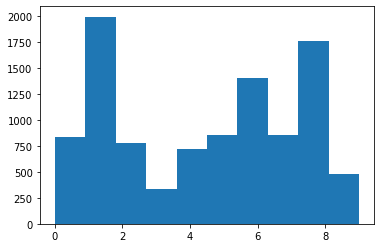

In [109]:
Y_pred = cifar10_net.forward(X_test).detach().cpu().argmax(axis=1)
print('Accuracy: ', accuracy(Y_test.numpy(), Y_pred.numpy()))

%matplotlib inline
plt.hist(Y_pred)
plt.show()